<a href="https://colab.research.google.com/github/EdithOroche/Proyecto_Simulaci-n/blob/main/Proyecto_Final_Simulacion_Sistemas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO – Simulación de Sistemas

## Optimización del tiempo de espera y atención en el restaurante “Mr Broaster” mediante simulación

**Curso:** Simulación de Sistemas  
**Docente:** MSc. Israel Nazareth Chaparro Cruz  
**Integrantes:**  
- Edith Claudia Oroche Aquino – 2021-119045  
- Leticia Lourdes Calderón Calizaya – 2021-119006  


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [98]:
# Diccionario con los archivos de cada día y sede
files = {
    ("Solari", "Miercoles"): "Datos_Miercoles.xlsx",
    ("Solari", "Viernes"):   "Datos_Viernes.xlsx",
    ("Solari", "Sabado"):    "Datos_Sabado.xlsx",
    ("AV",      "Viernes"):  "Datos_Viernes_AV.xlsx",
    ("AV",      "Sabado"):   "Datos_Sabado_AV.xlsx",
}

In [99]:
def excel_fraction_to_hhmmss(value):
    segundos_totales = int(round(float(value) * 24 * 3600))
    h = (segundos_totales // 3600) % 24
    m = (segundos_totales % 3600) // 60
    s = segundos_totales % 60
    return f"{h:02d}:{m:02d}:{s:02d}"


def normalize_time_cell(x):
    if pd.isna(x):
        return np.nan

    # 1) Fracción de día numérica
    if isinstance(x, (int, float, np.integer, np.floating)):
        return excel_fraction_to_hhmmss(x)

    # 2) Timestamp
    if isinstance(x, (pd.Timestamp, datetime)):
        return x.strftime("%H:%M:%S")

    # 3) String
    s = str(x).strip()
    if ":" in s:
        partes = s.split(":")
        try:
            h = int(partes[0])
            m = int(partes[1])
            s2 = int(float(partes[2])) if len(partes) > 2 else 0
            return f"{h:02d}:{m:02d}:{s2:02d}"
        except:
            return s

    return s


def parse_hhmmss_to_minutes(t_str):
    if pd.isna(t_str):
        return np.nan
    h, m, s = map(int, str(t_str).split(":"))
    return h * 60 + m + s / 60.0


In [100]:
def procesar_archivo_excel(filename, sede, dia):
    df = pd.read_excel(filename)
    df = df.rename(columns={
        "N°": "N",
        "Nº": "N",
        "Nro": "N",
        "Inicio de atención": "Inicio",
        "Inicio de atencion": "Inicio",
        "Fin de atención": "Fin",
        "Fin de atencion": "Fin",
        "Entrega de pedido": "Entrega",
    })

    # Asegurar el orden correcto
    df = df[["N", "Llegada", "Inicio", "Fin", "Entrega"]].copy()

    # Normalizar formato HH:MM:SS
    for col in ["Llegada", "Inicio", "Fin", "Entrega"]:
        df[col] = df[col].apply(normalize_time_cell)

    # Convertir a minutos
    df["t_llegada_min"] = df["Llegada"].apply(parse_hhmmss_to_minutes)
    df["t_inicio_min"]  = df["Inicio"].apply(parse_hhmmss_to_minutes)
    df["t_fin_min"]     = df["Fin"].apply(parse_hhmmss_to_minutes)
    df["t_entrega_min"] = df["Entrega"].apply(parse_hhmmss_to_minutes)

    # Ordenar por llegada
    df = df.sort_values("t_llegada_min").reset_index(drop=True)

    # === Variables derivadas EXACTAS que pediste ===
    df["Tiempo entre llegadas"] = df["t_llegada_min"].diff()
    df.loc[0, "Tiempo entre llegadas"] = np.nan

    df["Tiempo de llegada"]      = df["t_llegada_min"]
    df["Inicio de la atención"]  = df["t_inicio_min"]
    df["Tiempo de atención"]     = df["t_fin_min"] - df["t_inicio_min"]
    df["Fin de la atención"]     = df["t_fin_min"]
    df["Atención + espera"]      = df["t_fin_min"] - df["t_llegada_min"]
    df["Tiempo en espera"]       = df["t_inicio_min"] - df["t_llegada_min"]

    # Promedio acumulado
    df["Tiempo promedio en atención"] = df["Tiempo de atención"].expanding().mean()

    # Sede y día
    df["Sede"] = sede
    df["Dia"]  = dia

    return df


In [101]:
tablas = []

for (sede, dia), filename in files.items():
    print(f"Procesando: {sede} - {dia} desde {filename}")
    df_proc = procesar_archivo_excel(filename, sede, dia)
    tablas.append(df_proc)

df_all = pd.concat(tablas, ignore_index=True)

Procesando: Solari - Miercoles desde Datos_Miercoles.xlsx
Procesando: Solari - Viernes desde Datos_Viernes.xlsx
Procesando: Solari - Sabado desde Datos_Sabado.xlsx
Procesando: AV - Viernes desde Datos_Viernes_AV.xlsx
Procesando: AV - Sabado desde Datos_Sabado_AV.xlsx


In [102]:
cols_cuadro = [
    "N",
    "Tiempo entre llegadas",
    "Tiempo de llegada",
    "Inicio de la atención",
    "Tiempo de atención",
    "Fin de la atención",
    "Atención + espera",
    "Tiempo en espera",
    "Tiempo promedio en atención"
]

# 1) Solari - Miércoles
tabla_solari_miercoles = (
    df_all[(df_all["Sede"] == "Solari") & (df_all["Dia"] == "Miercoles")]
    [cols_cuadro]
    .reset_index(drop=True)
)
print("=== Solari - Miércoles ===")
display(tabla_solari_miercoles)

# 2) Solari - Viernes
tabla_solari_viernes = (
    df_all[(df_all["Sede"] == "Solari") & (df_all["Dia"] == "Viernes")]
    [cols_cuadro]
    .reset_index(drop=True)
)
print("=== Solari - Viernes ===")
display(tabla_solari_viernes)

# 3) Solari - Sábado
tabla_solari_sabado = (
    df_all[(df_all["Sede"] == "Solari") & (df_all["Dia"] == "Sabado")]
    [cols_cuadro]
    .reset_index(drop=True)
)
print("=== Solari - Sábado ===")
display(tabla_solari_sabado)

# 4) AV - Viernes
tabla_av_viernes = (
    df_all[(df_all["Sede"] == "AV") & (df_all["Dia"] == "Viernes")]
    [cols_cuadro]
    .reset_index(drop=True)
)
print("=== AV - Viernes ===")
display(tabla_av_viernes)

# 5) AV - Sábado
tabla_av_sabado = (
    df_all[(df_all["Sede"] == "AV") & (df_all["Dia"] == "Sabado")]
    [cols_cuadro]
    .reset_index(drop=True)
)
print("=== AV - Sábado ===")
display(tabla_av_sabado)


=== Solari - Miércoles ===


,N,Tiempo entre llegadas,Tiempo de llegada,Inicio de la atención,Tiempo de atención,Fin de la atención,Atención + espera,Tiempo en espera,Tiempo promedio en atención
0,1,NaN,1148.217,1148.617,0.350,1148.967,0.750,0.400,0.350
1,2,0.283,1148.500,1149.133,0.417,1149.550,1.050,0.633,0.383
2,3,2.617,1151.117,1151.250,0.500,1151.750,0.633,0.133,0.422
3,4,1.933,1153.050,1153.117,0.500,1153.617,0.567,0.067,0.442
4,5,0.983,1154.033,1154.083,0.467,1154.550,0.517,0.050,0.447
5,6,0.633,1154.667,1154.717,0.667,1155.383,0.717,0.050,0.483
6,7,1.517,1156.183,1156.233,0.400,1156.633,0.450,0.050,0.471
7,8,2.650,1158.833,1159.217,0.833,1160.050,1.217,0.383,0.517
8,9,1.667,1160.500,1160.883,0.717,1161.600,1.100,0.383,0.539
9,10,2.233,1162.733,1162.800,1.600,1164.400,1.667,0.067,0.645


=== Solari - Viernes ===


,N,Tiempo entre llegadas,Tiempo de llegada,Inicio de la atención,Tiempo de atención,Fin de la atención,Atención + espera,Tiempo en espera,Tiempo promedio en atención
0,1,NaN,1063.817,1063.850,0.683,1064.533,0.717,0.033,0.683
1,2,2.217,1066.033,1066.067,0.867,1066.933,0.900,0.033,0.775
2,3,0.700,1066.733,1066.933,0.783,1067.717,0.983,0.200,0.778
3,4,1.317,1068.050,1068.100,0.833,1068.933,0.883,0.050,0.792
4,5,1.600,1069.650,1069.683,0.967,1070.650,1.000,0.033,0.827
...,...,...,...,...,...,...,...,...,...
95,96,0.267,1202.750,1203.317,0.783,1204.100,1.350,0.567,0.929
96,97,2.200,1204.950,1205.000,1.500,1206.500,1.550,0.050,0.935
97,98,0.583,1205.533,1206.500,0.967,1207.467,1.933,0.967,0.935
98,99,0.050,1205.583,1207.467,0.967,1208.433,2.850,1.883,0.935


=== Solari - Sábado ===


,N,Tiempo entre llegadas,Tiempo de llegada,Inicio de la atención,Tiempo de atención,Fin de la atención,Atención + espera,Tiempo en espera,Tiempo promedio en atención
0,1,NaN,1080.400,1080.450,0.933,1081.383,0.983,0.050,0.933
1,2,0.433,1080.833,1081.383,0.900,1082.283,1.450,0.550,0.917
2,3,0.350,1081.183,1082.283,1.033,1083.317,2.133,1.100,0.956
3,4,1.683,1082.867,1083.317,1.717,1085.033,2.167,0.450,1.146
4,5,1.917,1084.783,1085.033,0.950,1085.983,1.200,0.250,1.107
...,...,...,...,...,...,...,...,...,...
105,106,1.517,1226.583,1226.633,0.767,1227.400,0.817,0.050,0.909
106,107,6.200,1232.783,1232.817,0.883,1233.700,0.917,0.033,0.909
107,108,0.300,1233.083,1233.700,0.967,1234.667,1.583,0.617,0.910
108,109,1.767,1234.850,1234.883,1.667,1236.550,1.700,0.033,0.917


=== AV - Viernes ===


,N,Tiempo entre llegadas,Tiempo de llegada,Inicio de la atención,Tiempo de atención,Fin de la atención,Atención + espera,Tiempo en espera,Tiempo promedio en atención
0,1,NaN,1081.933,1081.983,0.883,1082.867,0.933,0.050,0.883
1,2,3.300,1085.233,1085.283,0.950,1086.233,1.000,0.050,0.917
2,3,1.933,1087.167,1087.233,0.850,1088.083,0.917,0.067,0.894
3,4,2.817,1089.983,1090.033,0.950,1090.983,1.000,0.050,0.908
4,5,1.067,1091.050,1091.117,0.800,1091.917,0.867,0.067,0.887
...,...,...,...,...,...,...,...,...,...
100,101,3.817,1191.017,1191.067,1.367,1192.433,1.417,0.050,0.960
101,102,2.283,1193.300,1193.333,0.700,1194.033,0.733,0.033,0.957
102,103,4.400,1197.700,1197.750,0.900,1198.650,0.950,0.050,0.956
103,104,0.567,1198.267,1198.650,0.883,1199.533,1.267,0.383,0.956


=== AV - Sábado ===


,N,Tiempo entre llegadas,Tiempo de llegada,Inicio de la atención,Tiempo de atención,Fin de la atención,Atención + espera,Tiempo en espera,Tiempo promedio en atención
0,1,NaN,1117.517,1117.633,2.333,1119.967,2.450,0.117,2.333
1,2,3.100,1120.617,1120.667,0.850,1121.517,0.900,0.050,1.592
2,3,5.600,1126.217,1126.317,1.167,1127.483,1.267,0.100,1.450
3,4,1.483,1127.700,1127.833,1.017,1128.850,1.150,0.133,1.342
4,5,2.100,1129.800,1129.933,1.100,1131.033,1.233,0.133,1.293
...,...,...,...,...,...,...,...,...,...
110,111,2.533,1232.983,1289.900,1.183,1291.083,58.100,56.917,1.494
111,112,4.383,1237.367,1291.083,1.050,1292.133,54.767,53.717,1.490
112,113,1.133,1238.500,1292.133,1.433,1293.567,55.067,53.633,1.490
113,114,0.167,1238.667,1293.567,2.433,1296.000,57.333,54.900,1.498


##Tiempo acumulativo de las 2 sedes




In [103]:
def tiempo_llegada_acumulado(sede, dia):
    df_tmp = df_all[(df_all["Sede"] == sede) & (df_all["Dia"] == dia)].copy()
    if df_tmp.empty:
        print(f"No hay datos para {sede} - {dia}")
        return None, None
    df_tmp = df_tmp.sort_values("Tiempo de llegada").reset_index(drop=True)
    df_tmp["Tiempo de llegada (seg)"] = df_tmp["Tiempo de llegada"] * 60
    df_tmp["Tiempo entre llegadas (seg)"] = df_tmp["Tiempo de llegada (seg)"].diff().fillna(0)
    t_acum = np.cumsum(df_tmp["Tiempo entre llegadas (seg)"])
    x_vals = np.arange(len(t_acum))
    return x_vals, t_acum

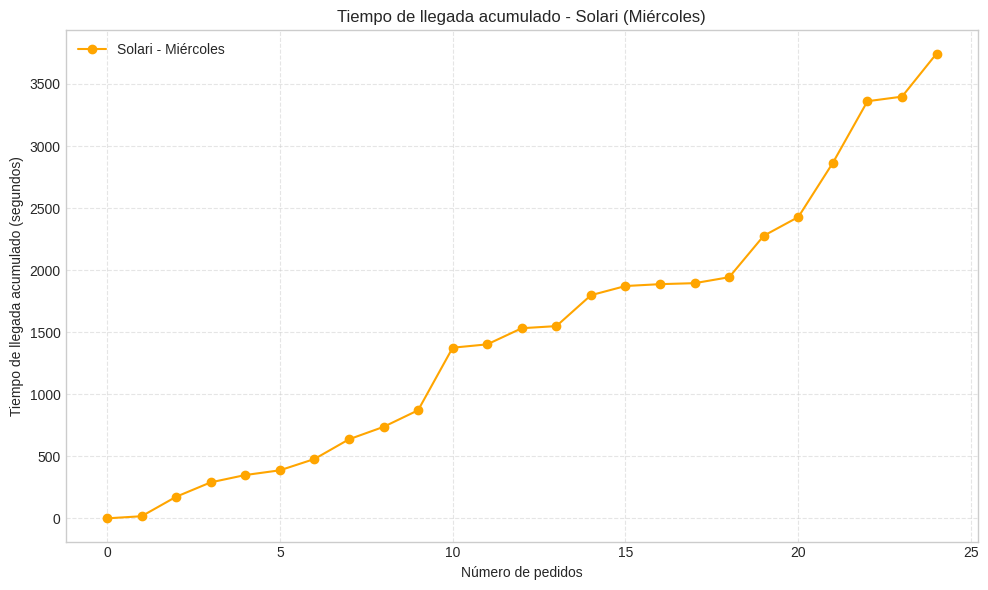

In [104]:
x_sol_m, t_sol_m = tiempo_llegada_acumulado("Solari", "Miercoles")

plt.figure(figsize=(10, 6))
if x_sol_m is not None:
    plt.plot(x_sol_m, t_sol_m, marker="o", color="orange", label="Solari - Miércoles")
plt.title("Tiempo de llegada acumulado - Solari (Miércoles)")
plt.xlabel("Número de pedidos")
plt.ylabel("Tiempo de llegada acumulado (segundos)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

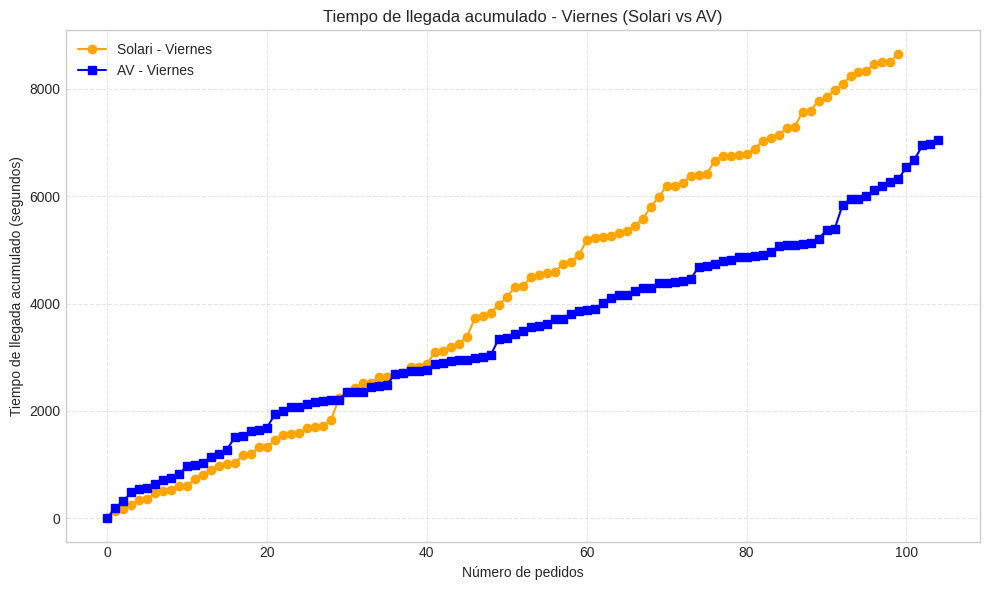

In [105]:
x_sol_v, t_sol_v = tiempo_llegada_acumulado("Solari", "Viernes")
x_av_v,  t_av_v  = tiempo_llegada_acumulado("AV", "Viernes")

plt.figure(figsize=(10, 6))
if x_sol_v is not None:
    plt.plot(x_sol_v, t_sol_v, marker="o", color="orange", label="Solari - Viernes")
if x_av_v is not None:
    plt.plot(x_av_v, t_av_v, marker="s", color="blue", label="AV - Viernes")
plt.title("Tiempo de llegada acumulado - Viernes (Solari vs AV)")
plt.xlabel("Número de pedidos")
plt.ylabel("Tiempo de llegada acumulado (segundos)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

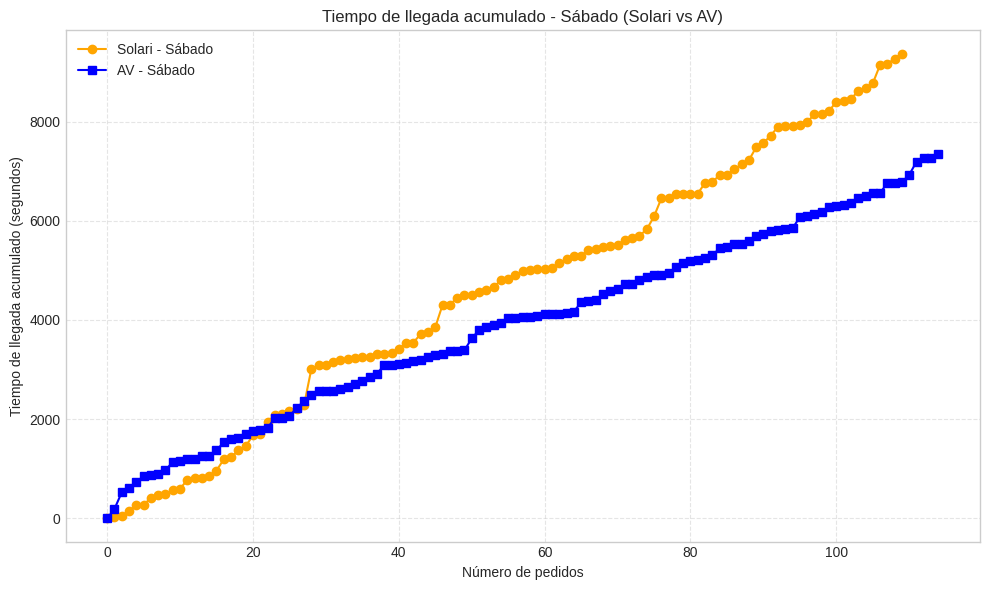

In [106]:
x_sol_s, t_sol_s = tiempo_llegada_acumulado("Solari", "Sabado")
x_av_s,  t_av_s  = tiempo_llegada_acumulado("AV", "Sabado")

plt.figure(figsize=(10, 6))
if x_sol_s is not None:
    plt.plot(x_sol_s, t_sol_s, marker="o", color="orange", label="Solari - Sábado")
if x_av_s is not None:
    plt.plot(x_av_s, t_av_s, marker="s", color="blue", label="AV - Sábado")
plt.title("Tiempo de llegada acumulado - Sábado (Solari vs AV)")
plt.xlabel("Número de pedidos")
plt.ylabel("Tiempo de llegada acumulado (segundos)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Resultados de la Prueba KS para Solari - Miércoles:
Estadístico KS: 0.2043, P-valor: 0.2159
No se rechaza que los datos sigan una Normal (α = 0.05).

Resultados de la Prueba KS para Solari - Viernes:
Estadístico KS: 0.2697, P-valor: 0.0000
Se rechaza que los datos sigan una Normal (α = 0.05).

Resultados de la Prueba KS para Solari - Sábado:
Estadístico KS: 0.2237, P-valor: 0.0000
Se rechaza que los datos sigan una Normal (α = 0.05).

Resultados de la Prueba KS para AV - Viernes:
Estadístico KS: 0.2693, P-valor: 0.0000
Se rechaza que los datos sigan una Normal (α = 0.05).

Resultados de la Prueba KS para AV - Sábado:
Estadístico KS: 0.0764, P-valor: 0.4893
No se rechaza que los datos sigan una Normal (α = 0.05).



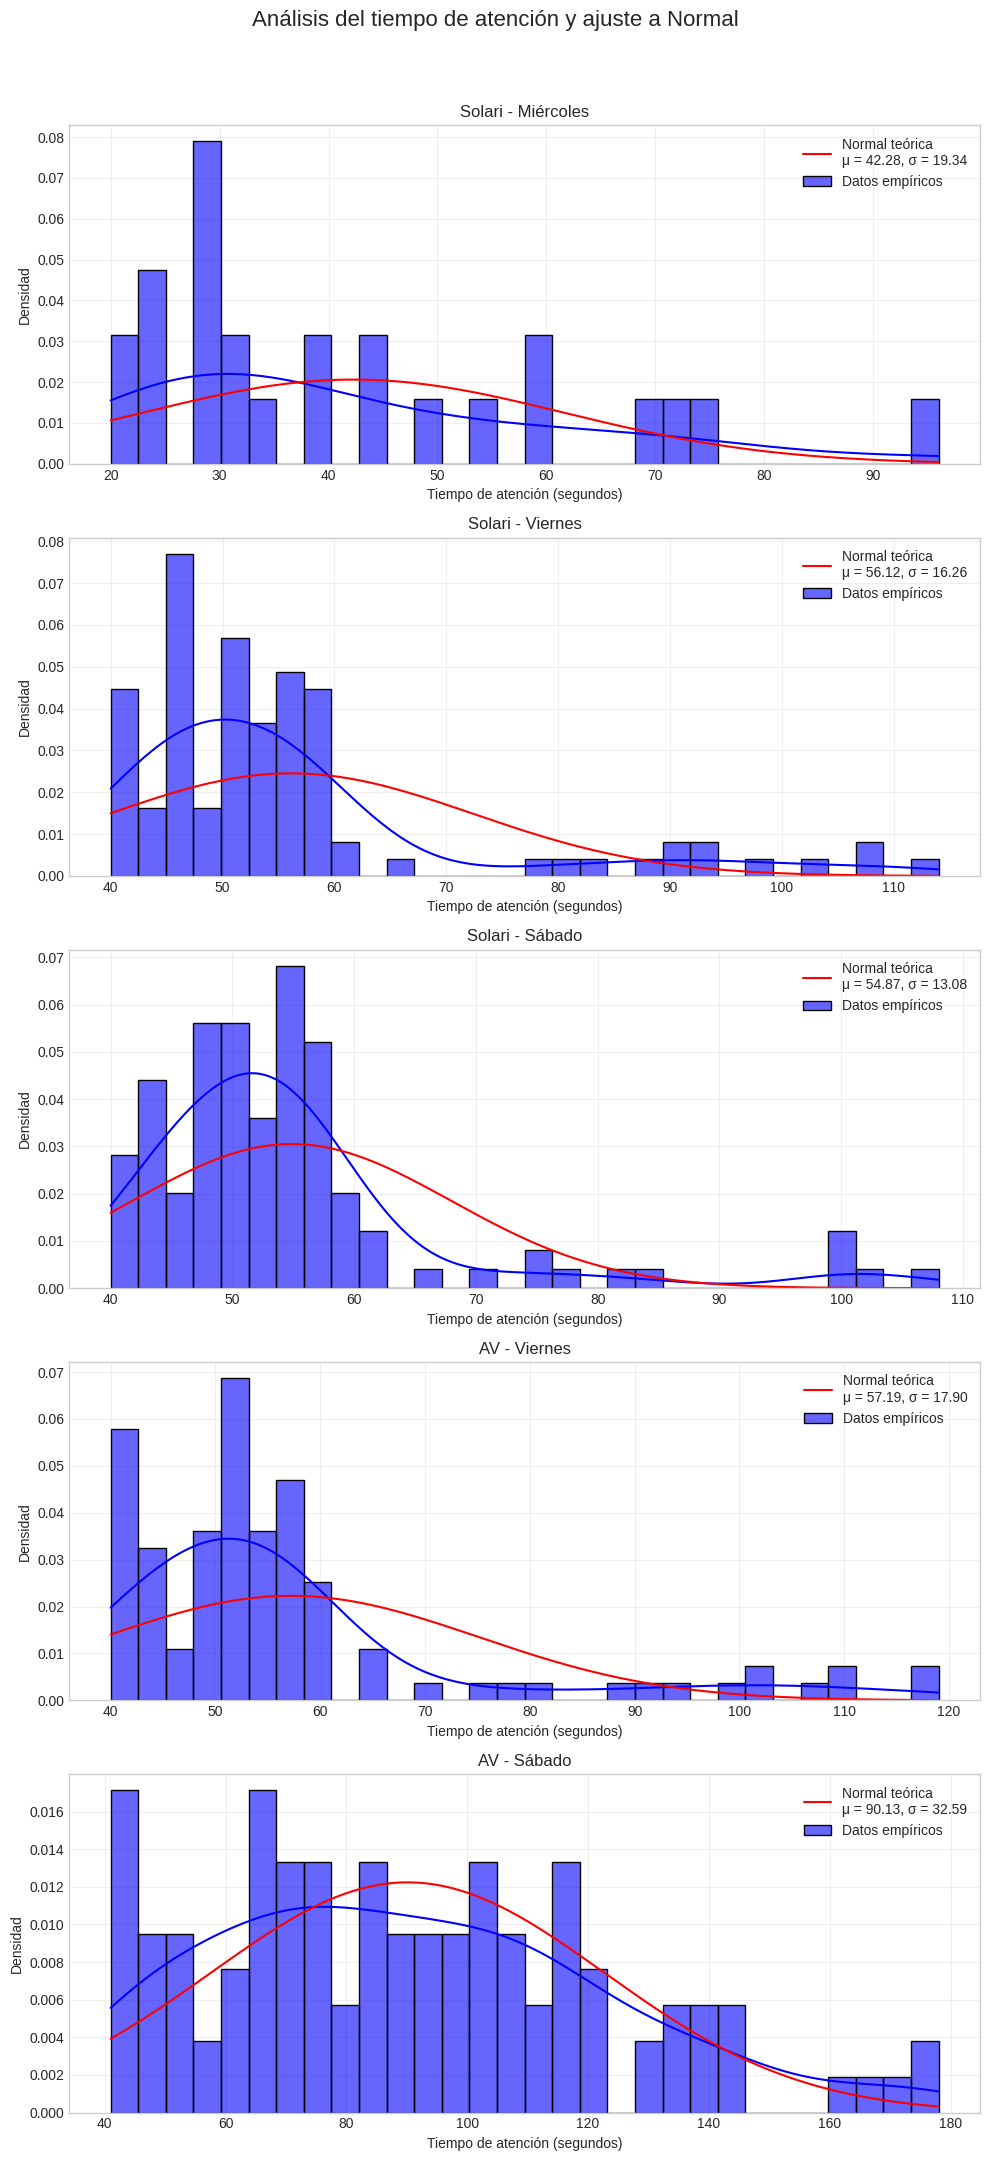

In [107]:
import seaborn as sns
from scipy import stats

# Función: histograma + ajuste Normal + prueba KS
def graficar_y_verificar_normal(data_min, nombre, ax):
    data = data_min.dropna() * 60  # pasar de minutos a segundos
    if len(data) == 0:
        ax.text(0.5, 0.5, f"Sin datos\n{nombre}", ha="center", va="center")
        ax.set_axis_off()
        print(f"Sin datos para {nombre}")
        return

    mu, sigma = np.mean(data), np.std(data)

    sns.histplot(data, bins=30, kde=True, stat="density",
                 color="blue", alpha=0.6, ax=ax, label="Datos empíricos")

    valores = np.linspace(np.min(data), np.max(data), 200)
    prob_teorica = stats.norm.pdf(valores, loc=mu, scale=sigma)
    ax.plot(valores, prob_teorica, "r-",
            label=f"Normal teórica\nμ = {mu:.2f}, σ = {sigma:.2f}")

    ax.set_title(nombre)
    ax.set_xlabel("Tiempo de atención (segundos)")
    ax.set_ylabel("Densidad")
    ax.legend()
    ax.grid(True, alpha=0.3)

    ks_stat, ks_pvalue = stats.kstest(data, "norm", args=(mu, sigma))
    print(f"Resultados de la Prueba KS para {nombre}:")
    print(f"Estadístico KS: {ks_stat:.4f}, P-valor: {ks_pvalue:.4f}")
    if ks_pvalue > 0.05:
        print("No se rechaza que los datos sigan una Normal (α = 0.05).\n")
    else:
        print("Se rechaza que los datos sigan una Normal (α = 0.05).\n")


# Series de tiempo de atención por sede y día
serie_sol_mie = df_all[(df_all["Sede"] == "Solari") & (df_all["Dia"] == "Miercoles")]["Tiempo de atención"]
serie_sol_vie = df_all[(df_all["Sede"] == "Solari") & (df_all["Dia"] == "Viernes")]["Tiempo de atención"]
serie_sol_sab = df_all[(df_all["Sede"] == "Solari") & (df_all["Dia"] == "Sabado")]["Tiempo de atención"]
serie_av_vie  = df_all[(df_all["Sede"] == "AV")      & (df_all["Dia"] == "Viernes")]["Tiempo de atención"]
serie_av_sab  = df_all[(df_all["Sede"] == "AV")      & (df_all["Dia"] == "Sabado")]["Tiempo de atención"]

fig, axes = plt.subplots(5, 1, figsize=(10, 22))
fig.suptitle("Análisis del tiempo de atención y ajuste a Normal", fontsize=16)

graficar_y_verificar_normal(serie_sol_mie, "Solari - Miércoles", axes[0])
graficar_y_verificar_normal(serie_sol_vie, "Solari - Viernes",   axes[1])
graficar_y_verificar_normal(serie_sol_sab, "Solari - Sábado",    axes[2])
graficar_y_verificar_normal(serie_av_vie,  "AV - Viernes",       axes[3])
graficar_y_verificar_normal(serie_av_sab,  "AV - Sábado",        axes[4])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [108]:
from scipy.stats import erlang, chi2
import numpy as np
import matplotlib.pyplot as plt

# Función: chi cuadrado para Erlang
def calcular_chi_cuadrado(datos_seg, k_estimado, lambda_estimado, num_intervalos=10):
    datos_seg = np.array(datos_seg)

    minimo, maximo = np.min(datos_seg), np.max(datos_seg)
    intervalos = np.linspace(minimo, maximo, num_intervalos + 1)

    frec_observada, _ = np.histogram(datos_seg, bins=intervalos)

    frec_esperada = []
    for i in range(len(intervalos) - 1):
        prob = erlang.cdf(intervalos[i + 1], k_estimado, scale=1 / lambda_estimado) - \
               erlang.cdf(intervalos[i],     k_estimado, scale=1 / lambda_estimado)
        frec_esperada.append(prob * len(datos_seg))
    frec_esperada = np.array(frec_esperada)

    chi_cuadrado = np.sum((frec_observada - frec_esperada) ** 2 / frec_esperada)
    grados_libertad = num_intervalos - 2
    p_valor = 1 - chi2.cdf(chi_cuadrado, grados_libertad)

    return chi_cuadrado, p_valor, frec_observada, frec_esperada, intervalos

Solari - Miercoles
Media: 42.2800 seg, Varianza: 374.1216
Parámetros estimados: k = 5, λ = 0.1130

Chi-cuadrado: 9.5763, P-valor: 0.2960
No se puede rechazar que los datos sigan una distribución Erlang (α = 0.05).


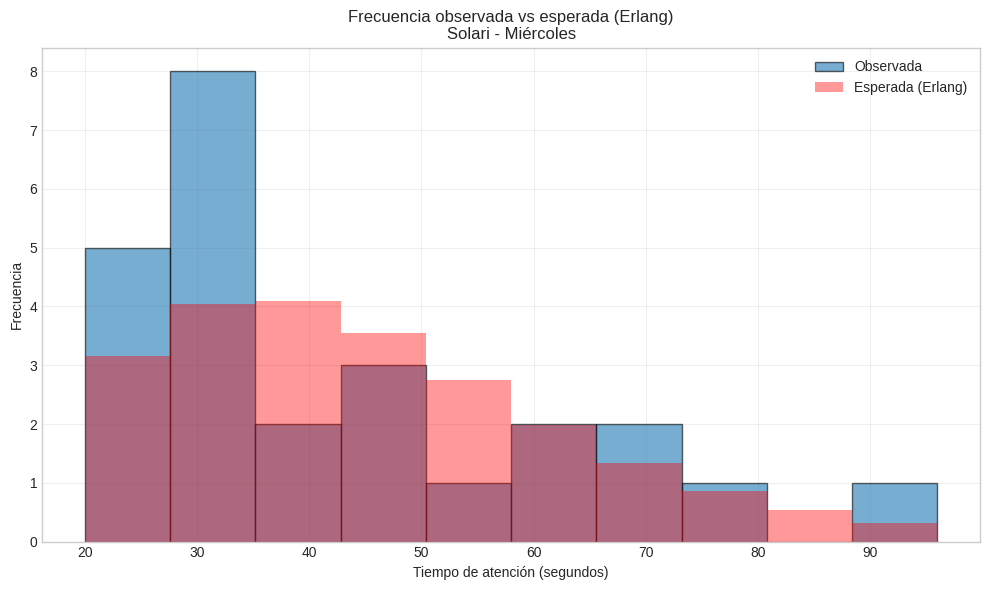

Solari - Viernes
Media: 56.1200 seg, Varianza: 264.5256
Parámetros: k = 12, λ = 0.2122
Chi-cuadrado: 73.3439, P-valor: 0.0000
✘ Se rechaza que NO sigue Erlang (α = 0.05).


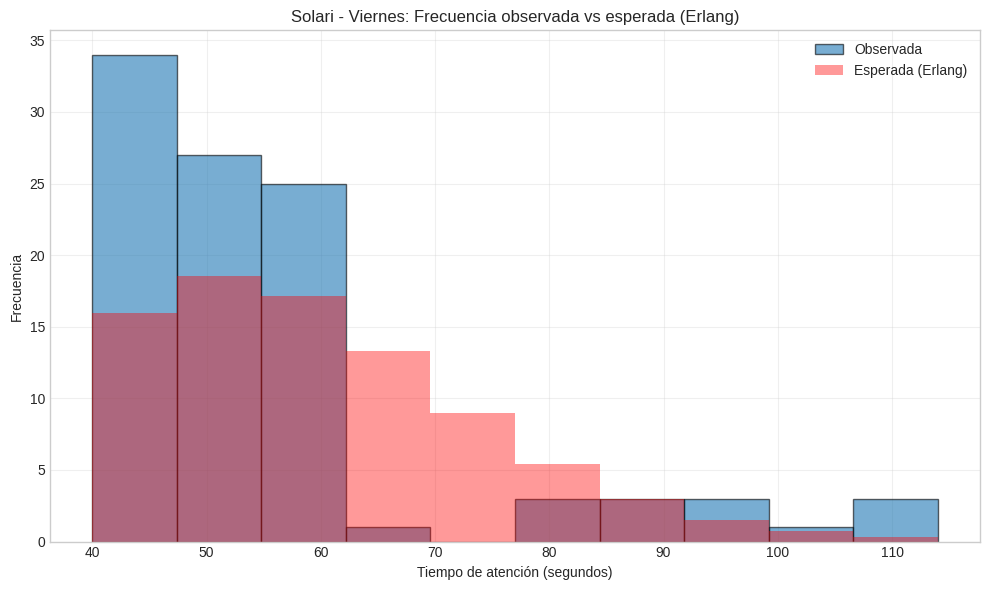

Solari - Sábado
Media: 54.8727 seg, Varianza: 171.1474
Parámetros: k = 18, λ = 0.3206
Chi-cuadrado: 75.9747, P-valor: 0.0000
✘ Se rechaza que NO sigue Erlang (α = 0.05).


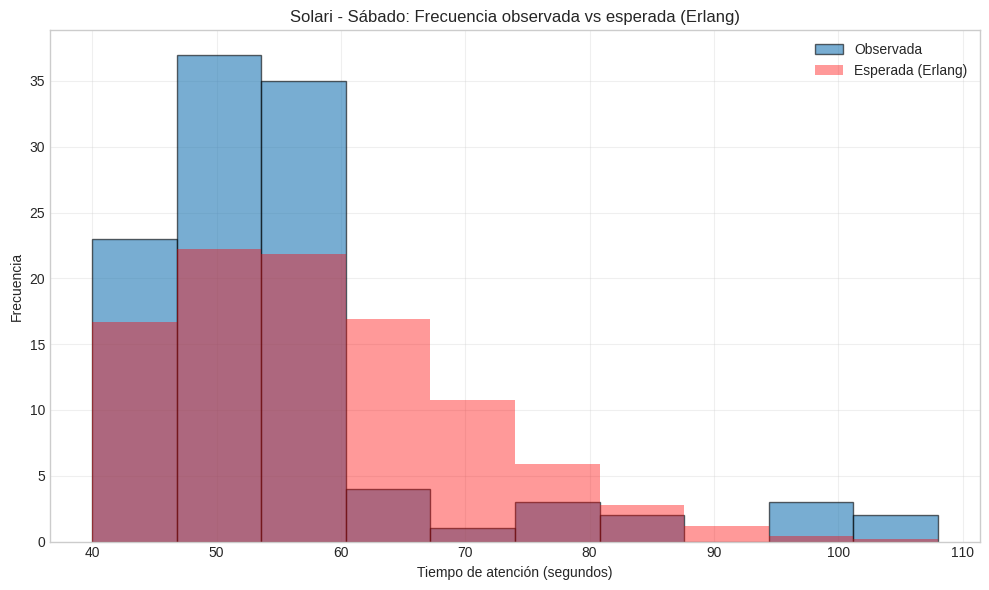

In [109]:
# Tomar tiempo de atención de Solari - Miércoles (en minutos) y pasar a segundos
tiempo_atencion_sol_mie_min = df_all[(df_all["Sede"] == "Solari") &
                                     (df_all["Dia"]  == "Miercoles")]["Tiempo de atención"].dropna()
tiempo_atencion_sol_mie = tiempo_atencion_sol_mie_min * 60  # a segundos

# Estimar parámetros k y lambda para Erlang
media = np.mean(tiempo_atencion_sol_mie)
varianza = np.var(tiempo_atencion_sol_mie)

lambda_est = media / varianza
k_est = round(media * lambda_est)
if k_est < 1:
    k_est = 1

print("Solari - Miercoles")
print(f"Media: {media:.4f} seg, Varianza: {varianza:.4f}")
print(f"Parámetros estimados: k = {k_est}, λ = {lambda_est:.4f}")

# Aplicar prueba de chi cuadrado
chi2_val, p_val, obs, esp, intv = calcular_chi_cuadrado(
    tiempo_atencion_sol_mie, k_est, lambda_est, num_intervalos=10
)

print(f"\nChi-cuadrado: {chi2_val:.4f}, P-valor: {p_val:.4f}")
if p_val > 0.05:
    print("No se puede rechazar que los datos sigan una distribución Erlang (α = 0.05).")
else:
    print("Se rechaza la hipótesis de que los datos sigan una distribución Erlang (α = 0.05).")

# Gráfico de frecuencias observadas vs esperadas
plt.figure(figsize=(10, 6))
plt.hist(tiempo_atencion_sol_mie, bins=intv, alpha=0.6,
         label="Observada", edgecolor="black")

centros = (intv[:-1] + intv[1:]) / 2
ancho = intv[1] - intv[0]
plt.bar(centros, esp, width=ancho, alpha=0.4,
        label="Esperada (Erlang)", color="red")

plt.xlabel("Tiempo de atención (segundos)")
plt.ylabel("Frecuencia")
plt.title("Frecuencia observada vs esperada (Erlang)\nSolari - Miércoles")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

tiempo_atencion_sol_vie_min = df_all[(df_all["Sede"] == "Solari") &
                                     (df_all["Dia"]  == "Viernes")]["Tiempo de atención"].dropna()

tiempo_atencion_sol_vie = tiempo_atencion_sol_vie_min * 60  # a segundos

# Parámetros estimados
media = np.mean(tiempo_atencion_sol_vie)
varianza = np.var(tiempo_atencion_sol_vie)
lambda_est = media / varianza
k_est = round(media * lambda_est)
if k_est < 1:
    k_est = 1

print("Solari - Viernes")
print(f"Media: {media:.4f} seg, Varianza: {varianza:.4f}")
print(f"Parámetros: k = {k_est}, λ = {lambda_est:.4f}")

# Función chi-cuadrado
def calcular_chi_cuadrado(datos_seg, k_estimado, lambda_estimado, num_intervalos=10):
    datos_seg = np.array(datos_seg)
    minimo, maximo = np.min(datos_seg), np.max(datos_seg)
    intervalos = np.linspace(minimo, maximo, num_intervalos + 1)
    frec_observada, _ = np.histogram(datos_seg, bins=intervalos)

    frec_esperada = []
    for i in range(len(intervalos) - 1):
        prob = erlang.cdf(intervalos[i + 1], k_estimado, scale=1/lambda_estimado) - \
               erlang.cdf(intervalos[i], k_estimado, scale=1/lambda_estimado)
        frec_esperada.append(prob * len(datos_seg))

    frec_esperada = np.array(frec_esperada)
    chi2_val = np.sum((frec_observada - frec_esperada)**2 / frec_esperada)
    gl = num_intervalos - 2
    p_valor = 1 - chi2.cdf(chi2_val, gl)

    return chi2_val, p_valor, frec_observada, frec_esperada, intervalos

chi2_val, p_val, obs, esp, intv = calcular_chi_cuadrado(tiempo_atencion_sol_vie, k_est, lambda_est)

print(f"Chi-cuadrado: {chi2_val:.4f}, P-valor: {p_val:.4f}")
if p_val > 0.05:
    print("✔ No se rechaza que sigue Erlang (α = 0.05).")
else:
    print("✘ Se rechaza que NO sigue Erlang (α = 0.05).")

# Gráfico
plt.figure(figsize=(10, 6))
plt.hist(tiempo_atencion_sol_vie, bins=intv, alpha=0.6, label="Observada", edgecolor="black")
centros = (intv[:-1] + intv[1:]) / 2
ancho = intv[1] - intv[0]
plt.bar(centros, esp, width=ancho, alpha=0.4, label="Esperada (Erlang)", color="red")
plt.title("Solari - Viernes: Frecuencia observada vs esperada (Erlang)")
plt.xlabel("Tiempo de atención (segundos)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


tiempo_atencion_sol_sab_min = df_all[(df_all["Sede"] == "Solari") &
                                     (df_all["Dia"]  == "Sabado")]["Tiempo de atención"].dropna()

tiempo_atencion_sol_sab = tiempo_atencion_sol_sab_min * 60  # a segundos

# Parámetros estimados
media = np.mean(tiempo_atencion_sol_sab)
varianza = np.var(tiempo_atencion_sol_sab)
lambda_est = media / varianza
k_est = round(media * lambda_est)
if k_est < 1:
    k_est = 1

print("Solari - Sábado")
print(f"Media: {media:.4f} seg, Varianza: {varianza:.4f}")
print(f"Parámetros: k = {k_est}, λ = {lambda_est:.4f}")

# Función chi-cuadrado ya definida en la celda anterior

chi2_val, p_val, obs, esp, intv = calcular_chi_cuadrado(tiempo_atencion_sol_sab, k_est, lambda_est)

print(f"Chi-cuadrado: {chi2_val:.4f}, P-valor: {p_val:.4f}")
if p_val > 0.05:
    print("✔ No se rechaza que sigue Erlang (α = 0.05).")
else:
    print("✘ Se rechaza que NO sigue Erlang (α = 0.05).")

# Gráfico
plt.figure(figsize=(10, 6))
plt.hist(tiempo_atencion_sol_sab, bins=intv, alpha=0.6, label="Observada", edgecolor="black")
centros = (intv[:-1] + intv[1:]) / 2
ancho = intv[1] - intv[0]
plt.bar(centros, esp, width=ancho, alpha=0.4, label="Esperada (Erlang)", color="red")
plt.title("Solari - Sábado: Frecuencia observada vs esperada (Erlang)")
plt.xlabel("Tiempo de atención (segundos)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

AV - Viernes
Media: 57.1905 seg, Varianza: 320.3637
Parámetros estimados: k = 10, λ = 0.1785
Chi-cuadrado: 58.4016, P-valor: 0.0000
✘ Se rechaza la hipótesis de distribución Erlang (α = 0.05).


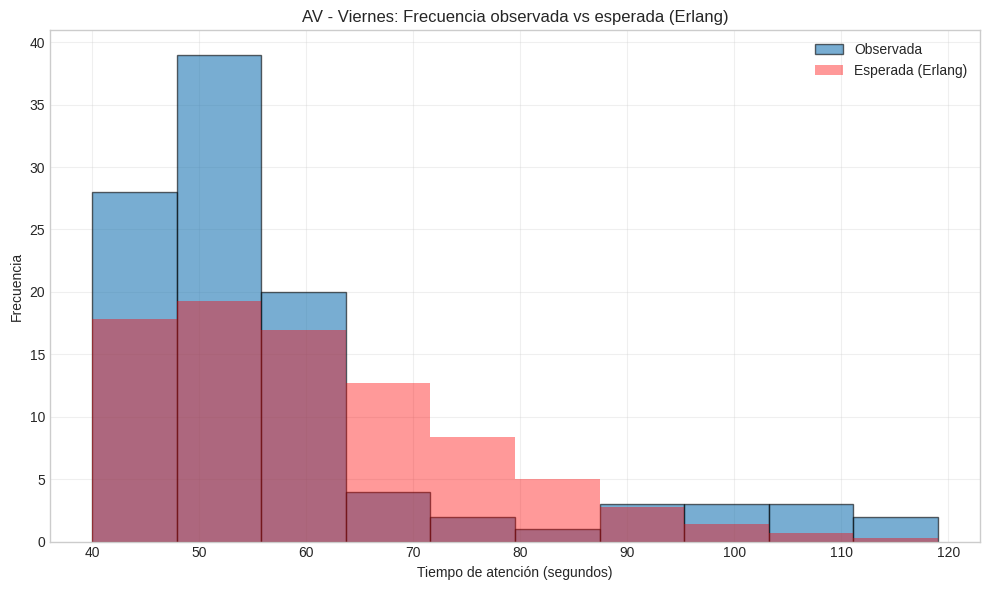

AV - Sábado
Media: 90.1304 seg, Varianza: 1062.0612
Parámetros estimados: k = 8, λ = 0.0849
Chi-cuadrado: 19.9630, P-valor: 0.0105
✘ Se rechaza la hipótesis de Erlang (α = 0.05).


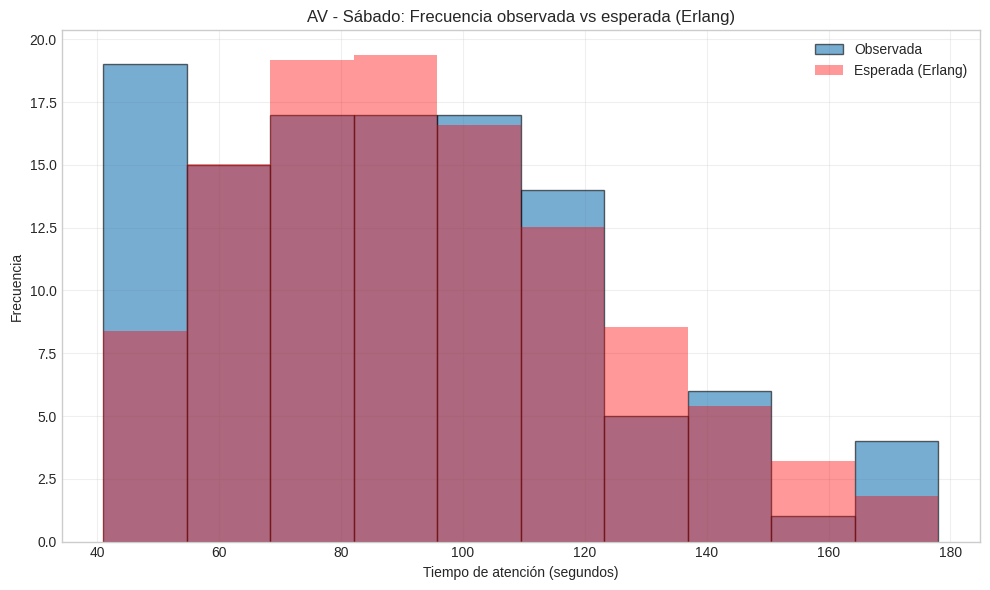

In [110]:
tiempo_atencion_av_vie_min = df_all[(df_all["Sede"] == "AV") &
                                    (df_all["Dia"]  == "Viernes")]["Tiempo de atención"].dropna()

tiempo_atencion_av_vie = tiempo_atencion_av_vie_min * 60  # convertir a segundos

# Estimación de parámetros
media = np.mean(tiempo_atencion_av_vie)
varianza = np.var(tiempo_atencion_av_vie)
lambda_est = media / varianza
k_est = round(media * lambda_est)
if k_est < 1:
    k_est = 1

print("AV - Viernes")
print(f"Media: {media:.4f} seg, Varianza: {varianza:.4f}")
print(f"Parámetros estimados: k = {k_est}, λ = {lambda_est:.4f}")

# Aplicar la función chi-cuadrado (ya definida antes)
chi2_val, p_val, obs, esp, intv = calcular_chi_cuadrado(
    tiempo_atencion_av_vie, k_est, lambda_est
)

print(f"Chi-cuadrado: {chi2_val:.4f}, P-valor: {p_val:.4f}")
if p_val > 0.05:
    print("✔ No se rechaza que sigue una distribución Erlang (α = 0.05).")
else:
    print("✘ Se rechaza la hipótesis de distribución Erlang (α = 0.05).")

# Gráfico
plt.figure(figsize=(10, 6))
plt.hist(tiempo_atencion_av_vie, bins=intv, alpha=0.6, label="Observada", edgecolor="black")

centros = (intv[:-1] + intv[1:]) / 2
ancho = intv[1] - intv[0]
plt.bar(centros, esp, width=ancho, alpha=0.4, label="Esperada (Erlang)", color="red")

plt.title("AV - Viernes: Frecuencia observada vs esperada (Erlang)")
plt.xlabel("Tiempo de atención (segundos)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


tiempo_atencion_av_sab_min = df_all[(df_all["Sede"] == "AV") &
                                    (df_all["Dia"]  == "Sabado")]["Tiempo de atención"].dropna()

tiempo_atencion_av_sab = tiempo_atencion_av_sab_min * 60  # convertir a segundos

# Estimación de parámetros
media = np.mean(tiempo_atencion_av_sab)
varianza = np.var(tiempo_atencion_av_sab)
lambda_est = media / varianza
k_est = round(media * lambda_est)
if k_est < 1:
    k_est = 1

print("AV - Sábado")
print(f"Media: {media:.4f} seg, Varianza: {varianza:.4f}")
print(f"Parámetros estimados: k = {k_est}, λ = {lambda_est:.4f}")

# Aplicar prueba chi-cuadrado
chi2_val, p_val, obs, esp, intv = calcular_chi_cuadrado(
    tiempo_atencion_av_sab, k_est, lambda_est
)

print(f"Chi-cuadrado: {chi2_val:.4f}, P-valor: {p_val:.4f}")
if p_val > 0.05:
    print("✔ No se rechaza que sigue Erlang (α = 0.05).")
else:
    print("✘ Se rechaza la hipótesis de Erlang (α = 0.05).")

# Gráfico
plt.figure(figsize=(10, 6))
plt.hist(tiempo_atencion_av_sab, bins=intv, alpha=0.6, label="Observada", edgecolor="black")

centros = (intv[:-1] + intv[1:]) / 2
ancho = intv[1] - intv[0]
plt.bar(centros, esp, width=ancho, alpha=0.4, label="Esperada (Erlang)", color="red")

plt.title("AV - Sábado: Frecuencia observada vs esperada (Erlang)")
plt.xlabel("Tiempo de atención (segundos)")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [111]:
from scipy import stats
import numpy as np

def prueba_chi_cuadrada_normal(data, nombre, alpha=0.05, num_bins=10):
    data = np.array(data)

    mu, sigma = np.mean(data), np.std(data)

    # Límites de intervalos
    bins = np.linspace(np.min(data), np.max(data), num_bins + 1)

    # Frecuencias observadas
    observadas, _ = np.histogram(data, bins=bins)

    # Frecuencias esperadas según Normal
    esperadas = []
    for i in range(len(bins) - 1):
        p = stats.norm.cdf(bins[i+1], mu, sigma) - stats.norm.cdf(bins[i], mu, sigma)
        esperadas.append(p * len(data))

    esperadas = np.array(esperadas)

    # Chi-cuadrada
    chi2 = np.sum((observadas - esperadas)**2 / esperadas)

    # Grados de libertad (k-1-p)
    gl = len(observadas) - 1 - 2
    valor_critico = stats.chi2.ppf(1 - alpha, gl)

    # Resultados
    print(f"\nPrueba de Chi-Cuadrada (Normalidad) — {nombre} ")
    print(f"Chi² calculado: {chi2:.4f}")
    print(f"Valor crítico (α={alpha}): {valor_critico:.4f}")
    print(f"Grados de libertad: {gl}")

    if chi2 < valor_critico:
        print("✔ No se rechaza la hipótesis de Normalidad (α = 0.05).")
    else:
        print("✘ Se rechaza la hipótesis de Normalidad (α = 0.05).")

In [112]:
data_sol_mie = df_all[(df_all["Sede"]=="Solari") &
                      (df_all["Dia"]=="Miercoles")]["Tiempo de atención"].dropna() * 60

prueba_chi_cuadrada_normal(data_sol_mie, "Solari - Miércoles")


data_sol_vie = df_all[(df_all["Sede"]=="Solari") &
                      (df_all["Dia"]=="Viernes")]["Tiempo de atención"].dropna() * 60

prueba_chi_cuadrada_normal(data_sol_vie, "Solari - Viernes")


data_sol_sab = df_all[(df_all["Sede"]=="Solari") &
                      (df_all["Dia"]=="Sabado")]["Tiempo de atención"].dropna() * 60

prueba_chi_cuadrada_normal(data_sol_sab, "Solari - Sábado")



Prueba de Chi-Cuadrada (Normalidad) — Solari - Miércoles 
Chi² calculado: 17.3760
Valor crítico (α=0.05): 14.0671
Grados de libertad: 7
✘ Se rechaza la hipótesis de Normalidad (α = 0.05).

Prueba de Chi-Cuadrada (Normalidad) — Solari - Viernes 
Chi² calculado: 181.1322
Valor crítico (α=0.05): 14.0671
Grados de libertad: 7
✘ Se rechaza la hipótesis de Normalidad (α = 0.05).

Prueba de Chi-Cuadrada (Normalidad) — Solari - Sábado 
Chi² calculado: 319.8664
Valor crítico (α=0.05): 14.0671
Grados de libertad: 7
✘ Se rechaza la hipótesis de Normalidad (α = 0.05).


In [113]:
data_av_vie = df_all[(df_all["Sede"]=="AV") &
                     (df_all["Dia"]=="Viernes")]["Tiempo de atención"].dropna() * 60

prueba_chi_cuadrada_normal(data_av_vie, "AV - Viernes")


data_av_sab = df_all[(df_all["Sede"]=="AV") &
                     (df_all["Dia"]=="Sabado")]["Tiempo de atención"].dropna() * 60

prueba_chi_cuadrada_normal(data_av_sab, "AV - Sábado")



Prueba de Chi-Cuadrada (Normalidad) — AV - Viernes 
Chi² calculado: 113.8374
Valor crítico (α=0.05): 14.0671
Grados de libertad: 7
✘ Se rechaza la hipótesis de Normalidad (α = 0.05).

Prueba de Chi-Cuadrada (Normalidad) — AV - Sábado 
Chi² calculado: 27.4187
Valor crítico (α=0.05): 14.0671
Grados de libertad: 7
✘ Se rechaza la hipótesis de Normalidad (α = 0.05).


##Histograma + ajuste a Exponencial + prueba KS

Resultados KS para Solari - Miércoles:
Estadístico KS: 0.1110, P-valor: 0.8976
No se rechaza que los datos sigan una Exponencial (α = 0.05).

Resultados KS para Solari - Viernes:
Estadístico KS: 0.0899, P-valor: 0.3785
No se rechaza que los datos sigan una Exponencial (α = 0.05).

Resultados KS para Solari - Sábado:
Estadístico KS: 0.0724, P-valor: 0.5920
No se rechaza que los datos sigan una Exponencial (α = 0.05).

Resultados KS para AV - Viernes:
Estadístico KS: 0.0522, P-valor: 0.9249
No se rechaza que los datos sigan una Exponencial (α = 0.05).

Resultados KS para AV - Sábado:
Estadístico KS: 0.0562, P-valor: 0.8448
No se rechaza que los datos sigan una Exponencial (α = 0.05).



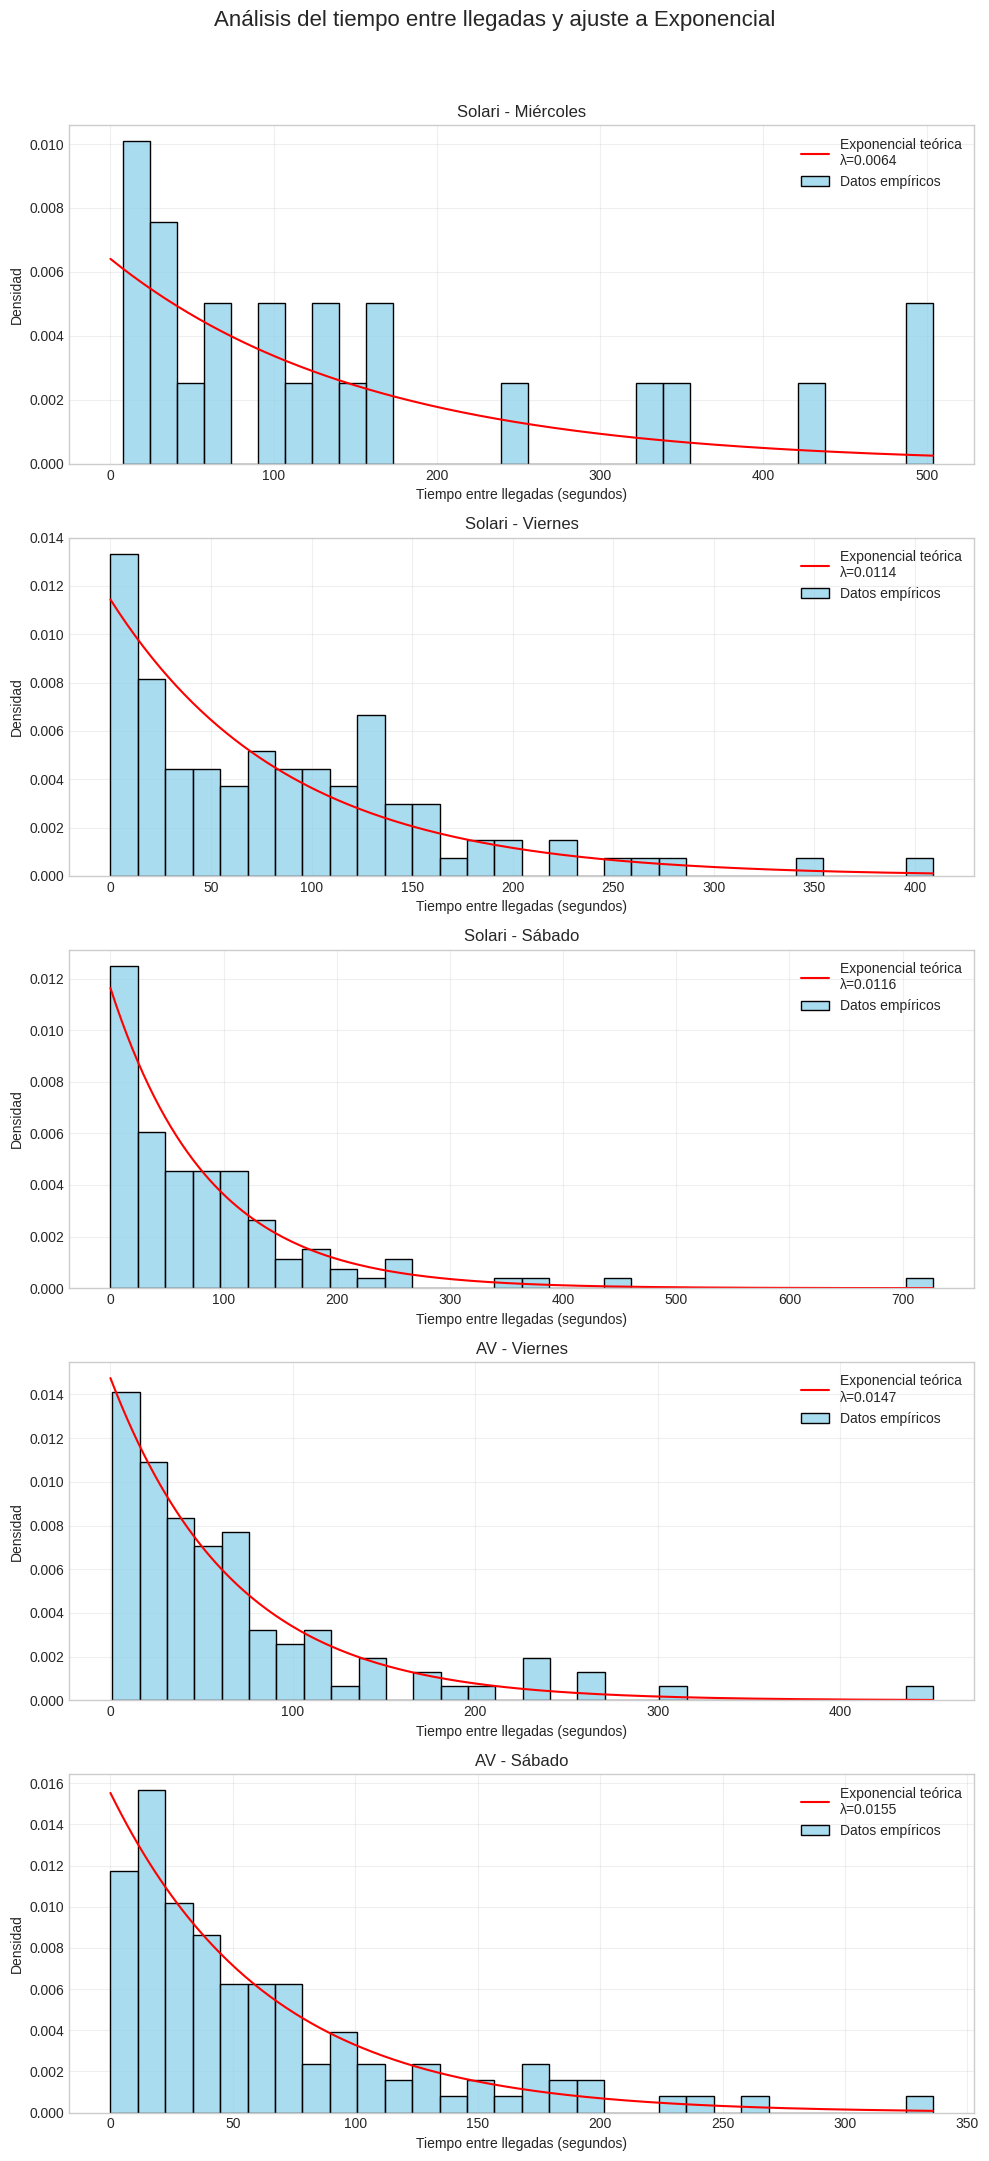

In [114]:
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

def graficar_y_verificar_exponencial(data_min, nombre, ax):
    # data_min: serie en minutos → pasamos a segundos
    data = data_min.dropna() * 60
    if len(data) == 0:
        ax.text(0.5, 0.5, f"Sin datos\n{nombre}", ha="center", va="center")
        ax.set_axis_off()
        print(f"Sin datos para {nombre}")
        return

    # Estimación de lambda (λ = 1 / media)
    media = np.mean(data)
    lam = 1 / media  # lambda

    # Histograma de datos
    sns.histplot(data, bins=30, stat="density", color="skyblue",
                 alpha=0.7, edgecolor="black", ax=ax, label="Datos empíricos")

    # Curva exponencial teórica
    x_vals = np.linspace(0, np.max(data), 300)
    y_teor = stats.expon.pdf(x_vals, scale=1/lam)
    ax.plot(x_vals, y_teor, "r-", label=f"Exponencial teórica\nλ={lam:.4f}")

    ax.set_title(nombre)
    ax.set_xlabel("Tiempo entre llegadas (segundos)")
    ax.set_ylabel("Densidad")
    ax.grid(alpha=0.3)
    ax.legend()

    # Prueba KS
    ks_stat, ks_p = stats.kstest(data, 'expon', args=(0, 1/lam))
    print(f"Resultados KS para {nombre}:")
    print(f"Estadístico KS: {ks_stat:.4f}, P-valor: {ks_p:.4f}")
    if ks_p > 0.05:
        print("No se rechaza que los datos sigan una Exponencial (α = 0.05).\n")
    else:
        print("Se rechaza la hipótesis de Exponencial (α = 0.05).\n")


# Series de TIEMPO ENTRE LLEGADAS por sede y día (en minutos)
serie_sol_mie = df_all[(df_all["Sede"]=="Solari") & (df_all["Dia"]=="Miercoles")]["Tiempo entre llegadas"]
serie_sol_vie = df_all[(df_all["Sede"]=="Solari") & (df_all["Dia"]=="Viernes")]["Tiempo entre llegadas"]
serie_sol_sab = df_all[(df_all["Sede"]=="Solari") & (df_all["Dia"]=="Sabado")]["Tiempo entre llegadas"]
serie_av_vie  = df_all[(df_all["Sede"]=="AV")      & (df_all["Dia"]=="Viernes")]["Tiempo entre llegadas"]
serie_av_sab  = df_all[(df_all["Sede"]=="AV")      & (df_all["Dia"]=="Sabado")]["Tiempo entre llegadas"]

fig, axes = plt.subplots(5, 1, figsize=(10, 22))
fig.suptitle("Análisis del tiempo entre llegadas y ajuste a Exponencial", fontsize=16)

graficar_y_verificar_exponencial(serie_sol_mie, "Solari - Miércoles", axes[0])
graficar_y_verificar_exponencial(serie_sol_vie, "Solari - Viernes",   axes[1])
graficar_y_verificar_exponencial(serie_sol_sab, "Solari - Sábado",    axes[2])
graficar_y_verificar_exponencial(serie_av_vie,  "AV - Viernes",       axes[3])
graficar_y_verificar_exponencial(serie_av_sab,  "AV - Sábado",        axes[4])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


##Prueba Chi-cuadrada para Exponencial


Prueba Chi² Exponencial — Solari - Miércoles
Chi² calculado: 12.4592
Valor crítico (α=0.05): 15.5073
Grados de libertad: 8
No se rechaza que el tiempo entre llegadas sigue Exponencial (α = 0.05).


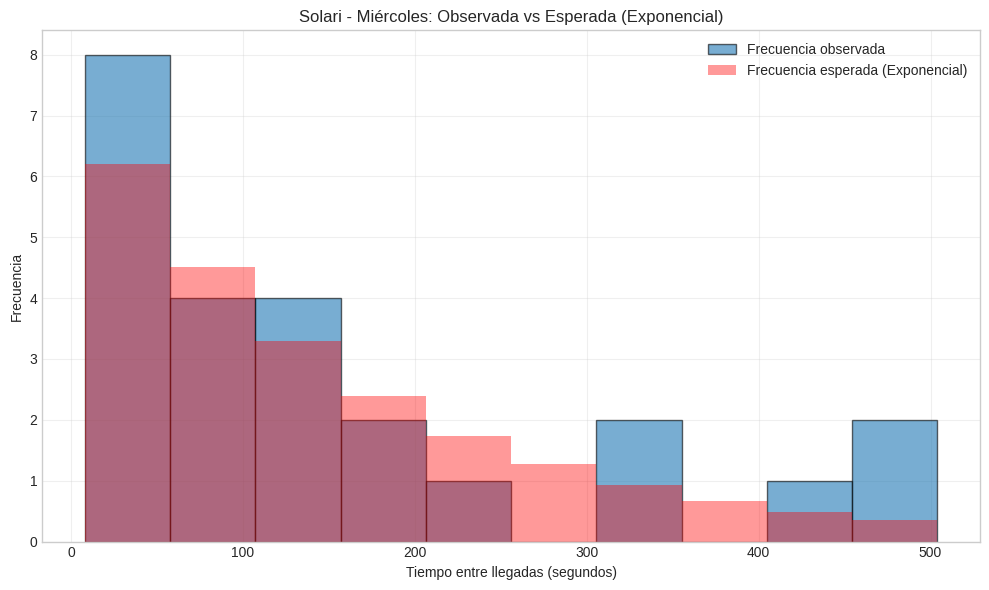


Prueba Chi² Exponencial — Solari - Viernes
Chi² calculado: 11.3928
Valor crítico (α=0.05): 15.5073
Grados de libertad: 8
No se rechaza que el tiempo entre llegadas sigue Exponencial (α = 0.05).


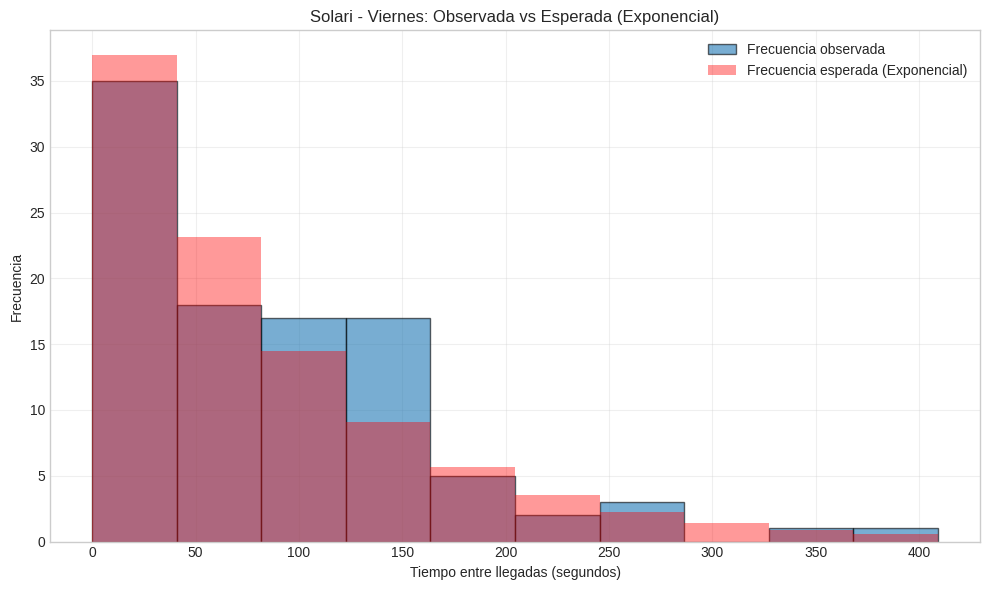


Prueba Chi² Exponencial — Solari - Sábado
Chi² calculado: 33.7267
Valor crítico (α=0.05): 15.5073
Grados de libertad: 8
Se rechaza la hipótesis de Exponencial (α = 0.05).


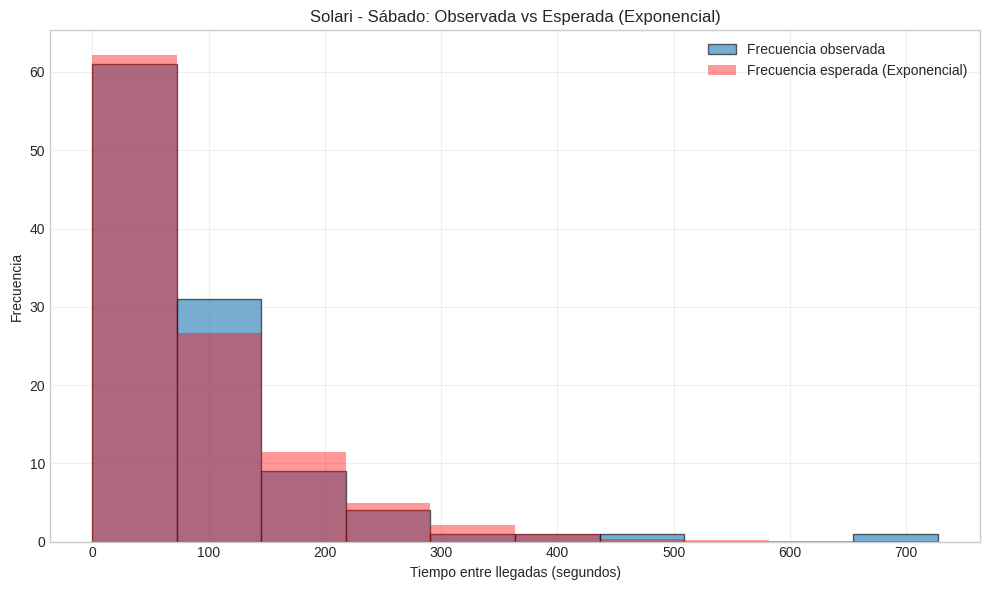


Prueba Chi² Exponencial — AV - Viernes
Chi² calculado: 14.6602
Valor crítico (α=0.05): 15.5073
Grados de libertad: 8
No se rechaza que el tiempo entre llegadas sigue Exponencial (α = 0.05).


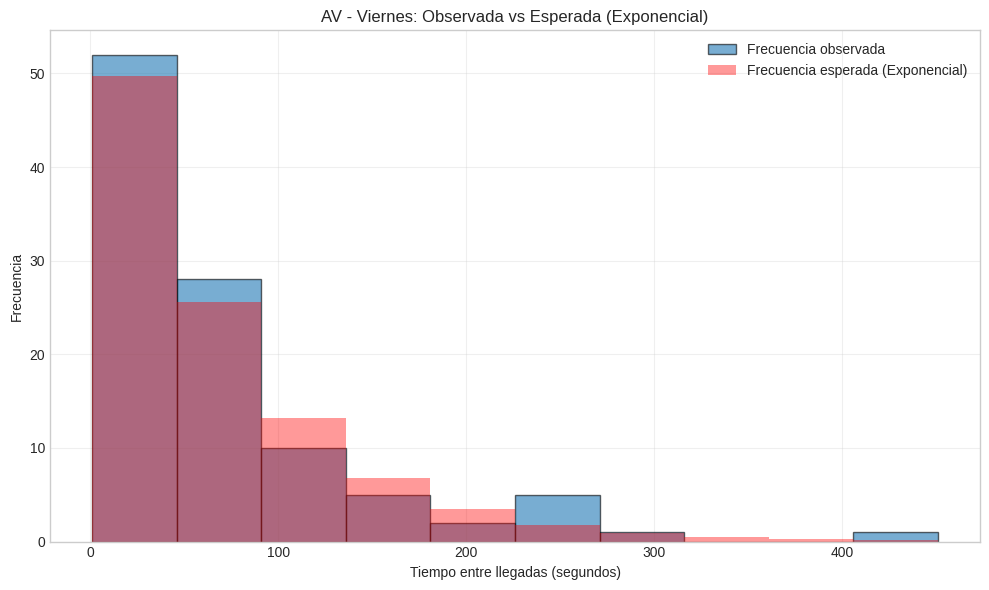


Prueba Chi² Exponencial — AV - Sábado
Chi² calculado: 7.2281
Valor crítico (α=0.05): 15.5073
Grados de libertad: 8
No se rechaza que el tiempo entre llegadas sigue Exponencial (α = 0.05).


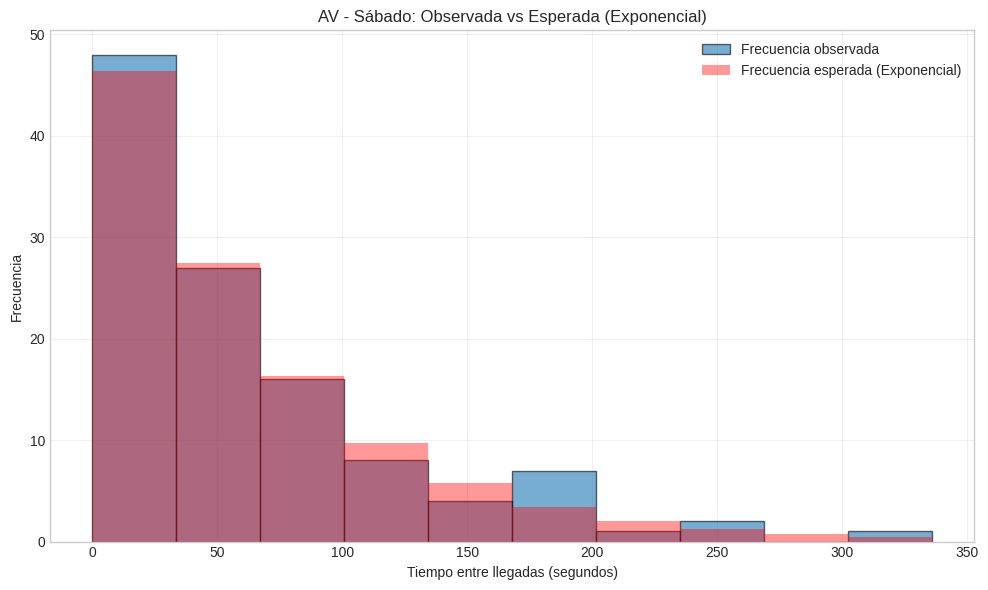

In [115]:
from scipy.stats import chi2, expon

def prueba_chi_cuadrada_exponencial(data_min, nombre, alpha=0.05, num_bins=10):
    data = data_min.dropna() * 60  # a segundos
    data = np.array(data)

    if len(data) < num_bins:
        print(f"\n{nombre}: muy pocos datos para Chi² (n={len(data)}).")
        return

    media = np.mean(data)
    lam = 1 / media

    # Intervalos
    minimo, maximo = np.min(data), np.max(data)
    bins = np.linspace(minimo, maximo, num_bins + 1)

    # Frecuencia observada
    obs, _ = np.histogram(data, bins=bins)

    # Frecuencia esperada según Exponencial
    esper = []
    for i in range(len(bins)-1):
        p = expon.cdf(bins[i+1], scale=1/lam) - expon.cdf(bins[i], scale=1/lam)
        esper.append(p * len(data))
    esper = np.array(esper)

    # Chi-cuadrada
    chi2_val = np.sum((obs - esper)**2 / esper)
    gl = len(obs) - 1 - 1  # k-1-parámetro (λ)
    crit = chi2.ppf(1 - alpha, gl)

    print(f"\nPrueba Chi² Exponencial — {nombre}")
    print(f"Chi² calculado: {chi2_val:.4f}")
    print(f"Valor crítico (α={alpha}): {crit:.4f}")
    print(f"Grados de libertad: {gl}")

    if chi2_val < crit:
        print("No se rechaza que el tiempo entre llegadas sigue Exponencial (α = 0.05).")
    else:
        print("Se rechaza la hipótesis de Exponencial (α = 0.05).")

    # Gráfico obs vs esperada
    plt.figure(figsize=(10,6))
    plt.hist(data, bins=bins, alpha=0.6, edgecolor="black", label="Frecuencia observada")
    centros = (bins[:-1] + bins[1:]) / 2
    ancho = bins[1] - bins[0]
    plt.bar(centros, esper, width=ancho, alpha=0.4, color="red", label="Frecuencia esperada (Exponencial)")
    plt.title(f"{nombre}: Observada vs Esperada (Exponencial)")
    plt.xlabel("Tiempo entre llegadas (segundos)")
    plt.ylabel("Frecuencia")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Aplicar a cada sede/día
prueba_chi_cuadrada_exponencial(serie_sol_mie, "Solari - Miércoles")
prueba_chi_cuadrada_exponencial(serie_sol_vie, "Solari - Viernes")
prueba_chi_cuadrada_exponencial(serie_sol_sab, "Solari - Sábado")
prueba_chi_cuadrada_exponencial(serie_av_vie,  "AV - Viernes")
prueba_chi_cuadrada_exponencial(serie_av_sab,  "AV - Sábado")

#SIMULACION DE ESCENARIIOS

##PARAMETROS POR SEDE

In [116]:
def obtener_parametros_sede_min(df_all, sede):
    """
    Calcula parámetros usando TODOS los días de una sede:
    - λ: tasa de llegadas (llegadas/minuto)
    - μ, σ: media y desviación estándar del tiempo de atención (minutos)
    """
    df_sede = df_all[df_all["Sede"] == sede].copy()

    interarr = df_sede["Tiempo entre llegadas"].dropna()   # en minutos
    servicio = df_sede["Tiempo de atención"].dropna()      # en minutos

    media_inter = interarr.mean()
    lam = 1 / media_inter       # llegadas por minuto
    mu = servicio.mean()        # tiempo de servicio medio (min)
    sigma = servicio.std()      # desvío estándar (min)

    print(f"=== Parámetros sede {sede} ===")
    print(f"Media entre llegadas : {media_inter:.4f} min  → λ = {lam:.4f} llegadas/min")
    print(f"Media tiempo servicio: {mu:.4f} min")
    print(f"Desv. estándar serv. : {sigma:.4f} min\n")

    return lam, mu, sigma

# Parámetros para cada sede (Solari y AV)
lam_solari, mu_solari, sigma_solari = obtener_parametros_sede_min(df_all, "Solari")
lam_av,     mu_av,     sigma_av     = obtener_parametros_sede_min(df_all, "AV")


=== Parámetros sede Solari ===
Media entre llegadas : 1.5639 min  → λ = 0.6394 llegadas/min
Media tiempo servicio: 0.9011 min
Desv. estándar serv. : 0.2637 min

=== Parámetros sede AV ===
Media entre llegadas : 1.1002 min  → λ = 0.9090 llegadas/min
Media tiempo servicio: 1.2402 min
Desv. estándar serv. : 0.5226 min



##Función de simulación para un escenario (n cajeros)

In [117]:
def simular_cola_escenario(num_clientes, lam_llegadas, mu_serv, sigma_serv,
                           num_cajeros, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # 1) Tiempos entre llegadas y tiempos de llegada acumulados
    tiempos_entre_llegadas = np.random.exponential(scale=1/lam_llegadas, size=num_clientes)
    tiempos_llegada = np.cumsum(tiempos_entre_llegadas)

    # 2) Tiempos de servicio (Normal truncada a 0)
    tiempos_servicio = np.random.normal(loc=mu_serv, scale=sigma_serv, size=num_clientes)
    tiempos_servicio = np.maximum(tiempos_servicio, 0)

    # 3) Estado de los cajeros: instante en que cada uno queda libre
    cajeros_libres = np.zeros(num_cajeros)

    tiempos_espera = np.zeros(num_clientes)
    tiempos_sistema = np.zeros(num_clientes)

    for i in range(num_clientes):
        t_llegada = tiempos_llegada[i]

        # Cajero que se libera primero
        idx_cajero = np.argmin(cajeros_libres)
        t_cajero_libre = cajeros_libres[idx_cajero]

        # Inicio y fin de servicio
        t_inicio = max(t_llegada, t_cajero_libre)
        t_fin = t_inicio + tiempos_servicio[i]

        # Actualizar instante en que ese cajero queda libre
        cajeros_libres[idx_cajero] = t_fin

        # Métricas por cliente
        tiempos_espera[i] = t_inicio - t_llegada
        tiempos_sistema[i] = t_fin - t_llegada

    # Horizonte simulado (tiempo total)
    horizonte = np.max(cajeros_libres)
    utilizacion_global = np.sum(tiempos_servicio) / (num_cajeros * horizonte)

    resultados = {
        "tiempo_promedio_espera":   np.mean(tiempos_espera),
        "tiempo_promedio_sistema":  np.mean(tiempos_sistema),
        "tiempo_promedio_servicio": np.mean(tiempos_servicio),
        "utilizacion":              utilizacion_global
    }
    return resultados


##Réplicas e intervalos de confianza 95 %



In [118]:
def intervalo_confianza_95(muestra):
    muestra = np.array(muestra)
    media = np.mean(muestra)
    s = np.std(muestra, ddof=1)
    n = len(muestra)
    error = 1.96 * s / np.sqrt(n)
    return media, media - error, media + error

def ejecutar_replicas_escenario(lam, mu, sigma, num_cajeros,
                                num_clientes=2000, num_replicas=30):
    esperas = []
    sistemas = []
    servicios = []
    utilizaciones = []

    for r in range(num_replicas):
        res = simular_cola_escenario(num_clientes, lam, mu, sigma,
                                     num_cajeros=num_cajeros, seed=100 + r)
        esperas.append(res["tiempo_promedio_espera"])
        sistemas.append(res["tiempo_promedio_sistema"])
        servicios.append(res["tiempo_promedio_servicio"])
        utilizaciones.append(res["utilizacion"])

    resumen = {
        "IC_espera":      intervalo_confianza_95(esperas),
        "IC_sistema":     intervalo_confianza_95(sistemas),
        "IC_servicio":    intervalo_confianza_95(servicios),
        "IC_utilizacion": intervalo_confianza_95(utilizaciones),
        "lista_espera":   esperas,
        "lista_sistema":  sistemas,
        "lista_servicio": servicios,
        "lista_utilizacion": utilizaciones
    }
    return resumen


##ESCENARIO PARA SOLARI

In [119]:
num_clientes = 2000      # número de clientes por réplica
num_replicas = 30        # réplicas por escenario

escenarios_solari = {
    "Escenario A (1 cajero)": 1,
    "Escenario B (2 cajeros)": 2,
    "Escenario C (3 cajeros)": 3
}

resumen_escenarios_solari = []

for nombre_esc, num_cajeros in escenarios_solari.items():
    resumen = ejecutar_replicas_escenario(lam_solari, mu_solari, sigma_solari,
                                          num_cajeros=num_cajeros,
                                          num_clientes=num_clientes,
                                          num_replicas=num_replicas)

    media_esp, li_esp, ls_esp = resumen["IC_espera"]
    media_sis, li_sis, ls_sis = resumen["IC_sistema"]
    media_ut,  li_ut,  ls_ut  = resumen["IC_utilizacion"]

    resumen_escenarios_solari.append({
        "Escenario": nombre_esc,
        "Cajeros": num_cajeros,
        "Espera_media_min":  media_esp,
        "Espera_IC_inf":     li_esp,
        "Espera_IC_sup":     ls_esp,
        "Sistema_media_min": media_sis,
        "Sistema_IC_inf":    li_sis,
        "Sistema_IC_sup":    ls_sis,
        "Utilizacion_media": media_ut,
        "Util_IC_inf":       li_ut,
        "Util_IC_sup":       ls_ut
    })

df_resumen_solari = pd.DataFrame(resumen_escenarios_solari)
print("=== Resumen de escenarios - Sede Solari ===")
display(df_resumen_solari)


=== Resumen de escenarios - Sede Solari ===


,Escenario,Cajeros,Espera_media_min,Espera_IC_inf,Espera_IC_sup,Sistema_media_min,Sistema_IC_inf,Sistema_IC_sup,Utilizacion_media,Util_IC_inf,Util_IC_sup
0,Escenario A (1 cajero),1,0.654,0.634,0.673,1.555,1.535,1.576,0.576,0.572,0.580
1,Escenario B (2 cajeros),2,0.051,0.049,0.052,0.952,0.949,0.955,0.288,0.286,0.290
2,Escenario C (3 cajeros),3,0.006,0.006,0.006,0.908,0.905,0.910,0.192,0.191,0.193


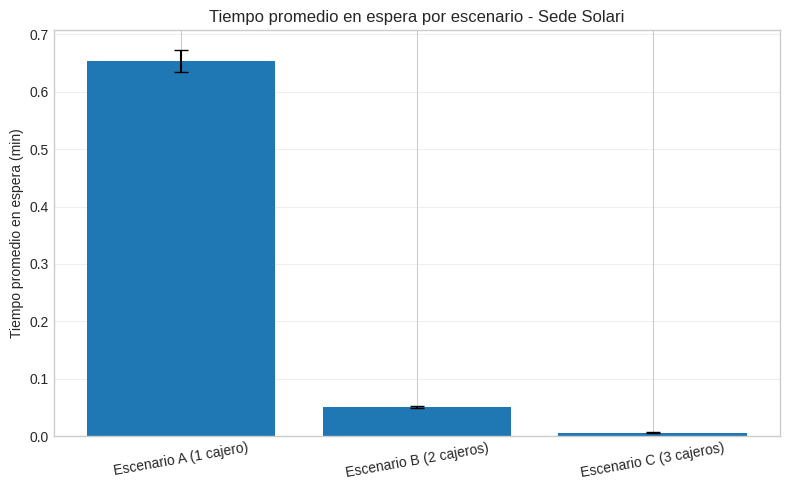

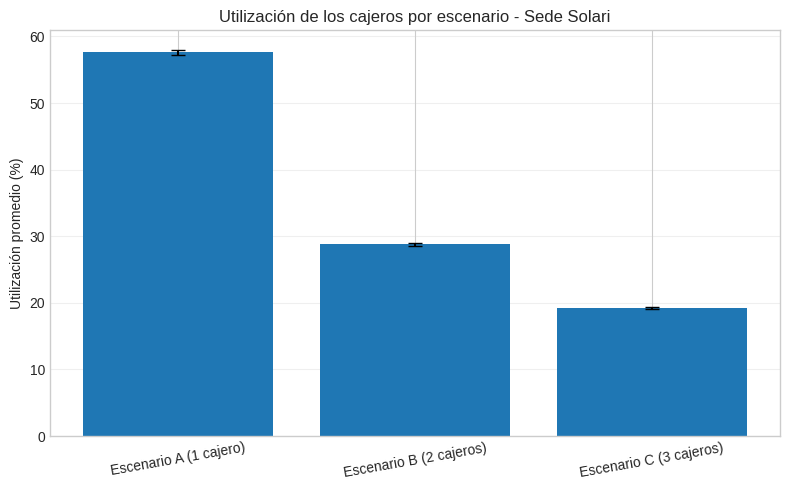

In [120]:
# 5.1 Tiempo promedio en espera (con barras e IC)
plt.figure(figsize=(8, 5))
plt.bar(
    df_resumen_solari["Escenario"],
    df_resumen_solari["Espera_media_min"],
    yerr=[
        df_resumen_solari["Espera_media_min"] - df_resumen_solari["Espera_IC_inf"],
        df_resumen_solari["Espera_IC_sup"] - df_resumen_solari["Espera_media_min"]
    ],
    capsize=5
)
plt.ylabel("Tiempo promedio en espera (min)")
plt.title("Tiempo promedio en espera por escenario - Sede Solari")
plt.xticks(rotation=10)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 5.2 Utilización de los cajeros
plt.figure(figsize=(8, 5))
plt.bar(
    df_resumen_solari["Escenario"],
    df_resumen_solari["Utilizacion_media"] * 100,
    yerr=[
        (df_resumen_solari["Utilizacion_media"] - df_resumen_solari["Util_IC_inf"]) * 100,
        (df_resumen_solari["Util_IC_sup"] - df_resumen_solari["Utilizacion_media"]) * 100
    ],
    capsize=5
)
plt.ylabel("Utilización promedio (%)")
plt.title("Utilización de los cajeros por escenario - Sede Solari")
plt.xticks(rotation=10)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


##ESCENARIO PARA AV

In [121]:
escenarios_av = {
    "Escenario A (1 cajero)": 1,
    "Escenario B (2 cajeros)": 2,
    "Escenario C (3 cajeros)": 3
}

resumen_escenarios_av = []

for nombre_esc, num_cajeros in escenarios_av.items():
    resumen = ejecutar_replicas_escenario(lam_av, mu_av, sigma_av,
                                          num_cajeros=num_cajeros,
                                          num_clientes=num_clientes,
                                          num_replicas=num_replicas)

    media_esp, li_esp, ls_esp = resumen["IC_espera"]
    media_sis, li_sis, ls_sis = resumen["IC_sistema"]
    media_ut,  li_ut,  ls_ut  = resumen["IC_utilizacion"]

    resumen_escenarios_av.append({
        "Escenario": nombre_esc,
        "Cajeros": num_cajeros,
        "Espera_media_min":  media_esp,
        "Espera_IC_inf":     li_esp,
        "Espera_IC_sup":     ls_esp,
        "Sistema_media_min": media_sis,
        "Sistema_IC_inf":    li_sis,
        "Sistema_IC_sup":    ls_sis,
        "Utilizacion_media": media_ut,
        "Util_IC_inf":       li_ut,
        "Util_IC_sup":       ls_ut
    })

df_resumen_av = pd.DataFrame(resumen_escenarios_av)
print("=== Resumen de escenarios - Sede AV ===")
display(df_resumen_av)


=== Resumen de escenarios - Sede AV ===


,Escenario,Cajeros,Espera_media_min,Espera_IC_inf,Espera_IC_sup,Sistema_media_min,Sistema_IC_inf,Sistema_IC_sup,Utilizacion_media,Util_IC_inf,Util_IC_sup
0,Escenario A (1 cajero),1,146.344,136.362,156.326,147.586,137.603,157.570,0.998,0.998,0.999
1,Escenario B (2 cajeros),2,0.347,0.334,0.361,1.590,1.574,1.606,0.564,0.560,0.568
2,Escenario C (3 cajeros),3,0.053,0.050,0.055,1.296,1.290,1.301,0.376,0.373,0.379


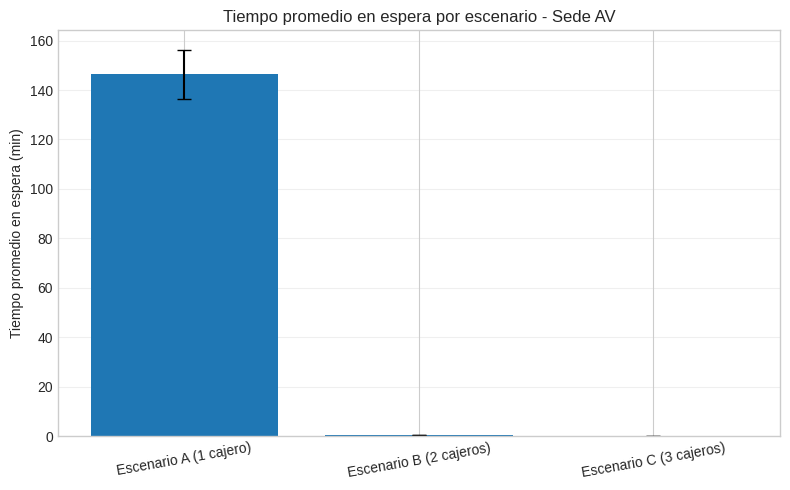

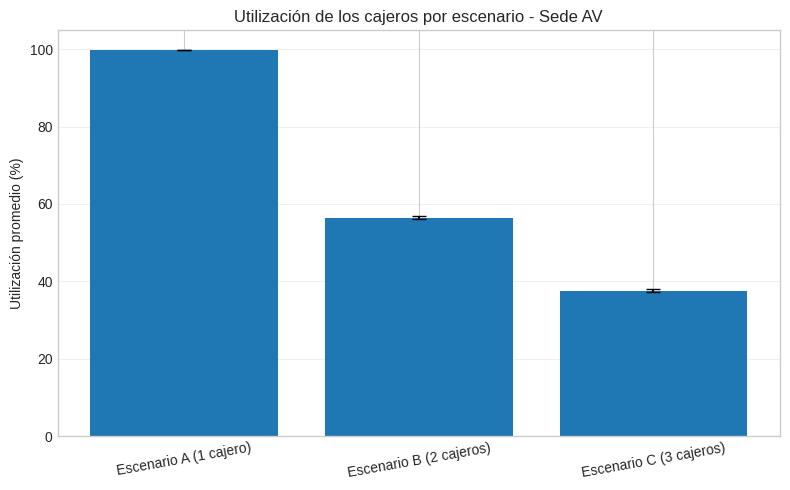

In [122]:
# 7.1 Tiempo promedio en espera
plt.figure(figsize=(8, 5))
plt.bar(
    df_resumen_av["Escenario"],
    df_resumen_av["Espera_media_min"],
    yerr=[
        df_resumen_av["Espera_media_min"] - df_resumen_av["Espera_IC_inf"],
        df_resumen_av["Espera_IC_sup"] - df_resumen_av["Espera_media_min"]
    ],
    capsize=5
)
plt.ylabel("Tiempo promedio en espera (min)")
plt.title("Tiempo promedio en espera por escenario - Sede AV")
plt.xticks(rotation=10)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 7.2 Utilización de los cajeros
plt.figure(figsize=(8, 5))
plt.bar(
    df_resumen_av["Escenario"],
    df_resumen_av["Utilizacion_media"] * 100,
    yerr=[
        (df_resumen_av["Utilizacion_media"] - df_resumen_av["Util_IC_inf"]) * 100,
        (df_resumen_av["Util_IC_sup"] - df_resumen_av["Utilizacion_media"]) * 100
    ],
    capsize=5
)
plt.ylabel("Utilización promedio (%)")
plt.title("Utilización de los cajeros por escenario - Sede AV")
plt.xticks(rotation=10)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


#Comparación entre sedes en el escenario con 2 cajeros

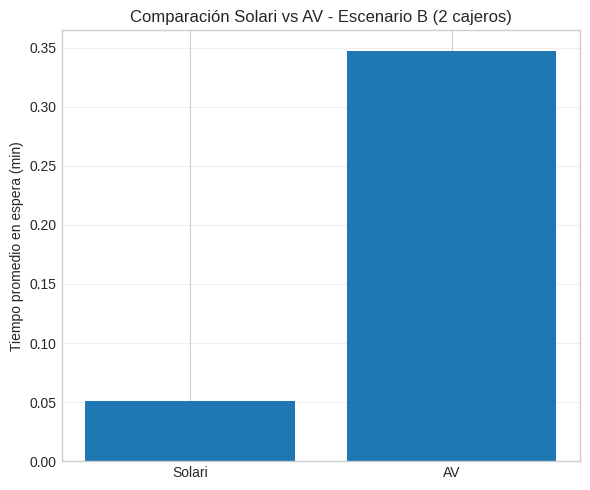

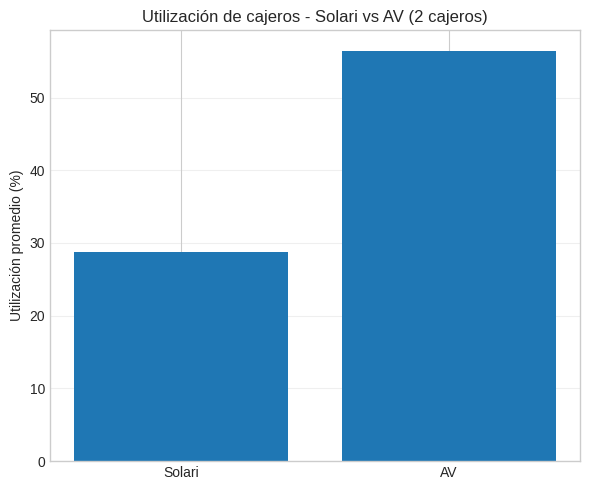

In [123]:
esc_sol_B = df_resumen_solari[df_resumen_solari["Cajeros"] == 2].iloc[0]
esc_av_B  = df_resumen_av[df_resumen_av["Cajeros"] == 2].iloc[0]

# 8.1 Tiempo promedio en espera
plt.figure(figsize=(6, 5))
sedes = ["Solari", "AV"]
esperas_medias = [esc_sol_B["Espera_media_min"], esc_av_B["Espera_media_min"]]
plt.bar(sedes, esperas_medias)
plt.ylabel("Tiempo promedio en espera (min)")
plt.title("Comparación Solari vs AV - Escenario B (2 cajeros)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 8.2 Utilización promedio
plt.figure(figsize=(6, 5))
util_medias = [esc_sol_B["Utilizacion_media"] * 100, esc_av_B["Utilizacion_media"] * 100]
plt.bar(sedes, util_medias)
plt.ylabel("Utilización promedio (%)")
plt.title("Utilización de cajeros - Solari vs AV (2 cajeros)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


#OPCION 2


##Parámetros para la simulación

In [124]:
# Día normal = Solari (Miércoles + Viernes)
mask_semana_solari = (df_all["Sede"] == "Solari") & (df_all["Dia"].isin(["Miercoles", "Viernes"]))
interarr_semana = df_all.loc[mask_semana_solari, "Tiempo entre llegadas"].dropna()
serv_semana      = df_all.loc[mask_semana_solari, "Tiempo de atención"].dropna()

# Fin de semana = Solari (Sábado)
mask_finde_solari = (df_all["Sede"] == "Solari") & (df_all["Dia"] == "Sabado")
interarr_finde = df_all.loc[mask_finde_solari, "Tiempo entre llegadas"].dropna()
serv_finde      = df_all.loc[mask_finde_solari, "Tiempo de atención"].dropna()

# Parámetros en MINUTOS
lam_semana = 1 / interarr_semana.mean()   # λ llegadas/min
mu_semana  = serv_semana.mean()           # media servicio
sig_semana = serv_semana.std()            # desviación

lam_finde = 1 / interarr_finde.mean()
mu_finde  = serv_finde.mean()
sig_finde = serv_finde.std()

print("Parámetros estimados para Solari")
print(f"Día normal (Miércoles + Viernes): λ = {lam_semana:.4f} lleg/min, μ = {mu_semana:.4f} min, σ = {sig_semana:.4f} min")
print(f"Fin de semana (Sábado)         : λ = {lam_finde:.4f} lleg/min, μ = {mu_finde:.4f} min, σ = {sig_finde:.4f} min")


Parámetros estimados para Solari
Día normal (Miércoles + Viernes): λ = 0.5952 lleg/min, μ = 0.8892 min, σ = 0.2980 min
Fin de semana (Sábado)         : λ = 0.6980 lleg/min, μ = 0.9145 min, σ = 0.2190 min


##Función de simulación con 2 cajeros

In [125]:
def simular_dos_cajeros(num_pedidos, lam_llegadas, mu_serv, sigma_serv, num_cajeros=2, seed=None):
    """
    Simula un día de atención con 'num_cajeros' cajeros.
    Devuelve el vector del tiempo promedio en el sistema
    (llegada → fin de atención) para cada número de pedido,
    el vector de tiempos en el sistema para cada pedido,
    y un diccionario de métricas agregadas.
    Unidades internas: minutos.
    """
    if seed is not None:
        np.random.seed(seed)

    # Tiempos entre llegadas (Exponencial) y tiempos de llegada acumulados
    tiempos_entre_llegadas = np.random.exponential(scale=1/lam_llegadas, size=num_pedidos)
    tiempos_llegada = np.cumsum(tiempos_entre_llegadas)

    # Tiempos de servicio (Normal, truncados a positivo)
    tiempos_servicio = np.random.normal(loc=mu_serv, scale=sigma_serv, size=num_pedidos)
    tiempos_servicio = np.maximum(tiempos_servicio, 0.01)  # mínimo 0.01 min

    # Estado de los cajeros: instante en que cada cajero queda libre
    cajeros_libres = np.zeros(num_cajeros)

    # Vectores de resultados por cliente
    tiempos_espera = np.zeros(num_pedidos)
    tiempos_en_sistema = np.zeros(num_pedidos)

    for i in range(num_pedidos):
        t_llegada = tiempos_llegada[i]

        # Cajero que se libera antes
        idx = np.argmin(cajeros_libres)
        t_libre = cajeros_libres[idx]

        # Inicio y fin de la atención
        t_inicio = max(t_llegada, t_libre)
        t_fin = t_inicio + tiempos_servicio[i]

        cajeros_libres[idx] = t_fin

        # Métricas por cliente
        tiempos_espera[i] = t_inicio - t_llegada
        tiempos_en_sistema[i] = t_fin - t_llegada


    # Tiempo en el sistema por pedido (minutos)
    tiempo_sistema = tiempos_en_sistema

    # Tiempo promedio acumulado en el sistema (minutos)
    tiempo_promedio_acumulado = np.cumsum(tiempo_sistema) / np.arange(1, num_pedidos + 1)

    # Métricas agregadas
    horizonte = np.max(cajeros_libres)
    utilizacion_global = np.sum(tiempos_servicio) / (num_cajeros * horizonte)

    metricas_agregadas = {
        "tiempo_prom_sistema": np.mean(tiempos_en_sistema),
        "tiempo_prom_cola":    np.mean(tiempos_espera),
        "utilizacion":         utilizacion_global,
        "num_promedio_cola":   lam_llegadas * np.mean(tiempos_espera) # Little's Law: Lq = λ * Wq
    }

    return tiempo_promedio_acumulado, tiempo_sistema, metricas_agregadas


##Réplicas para día normal

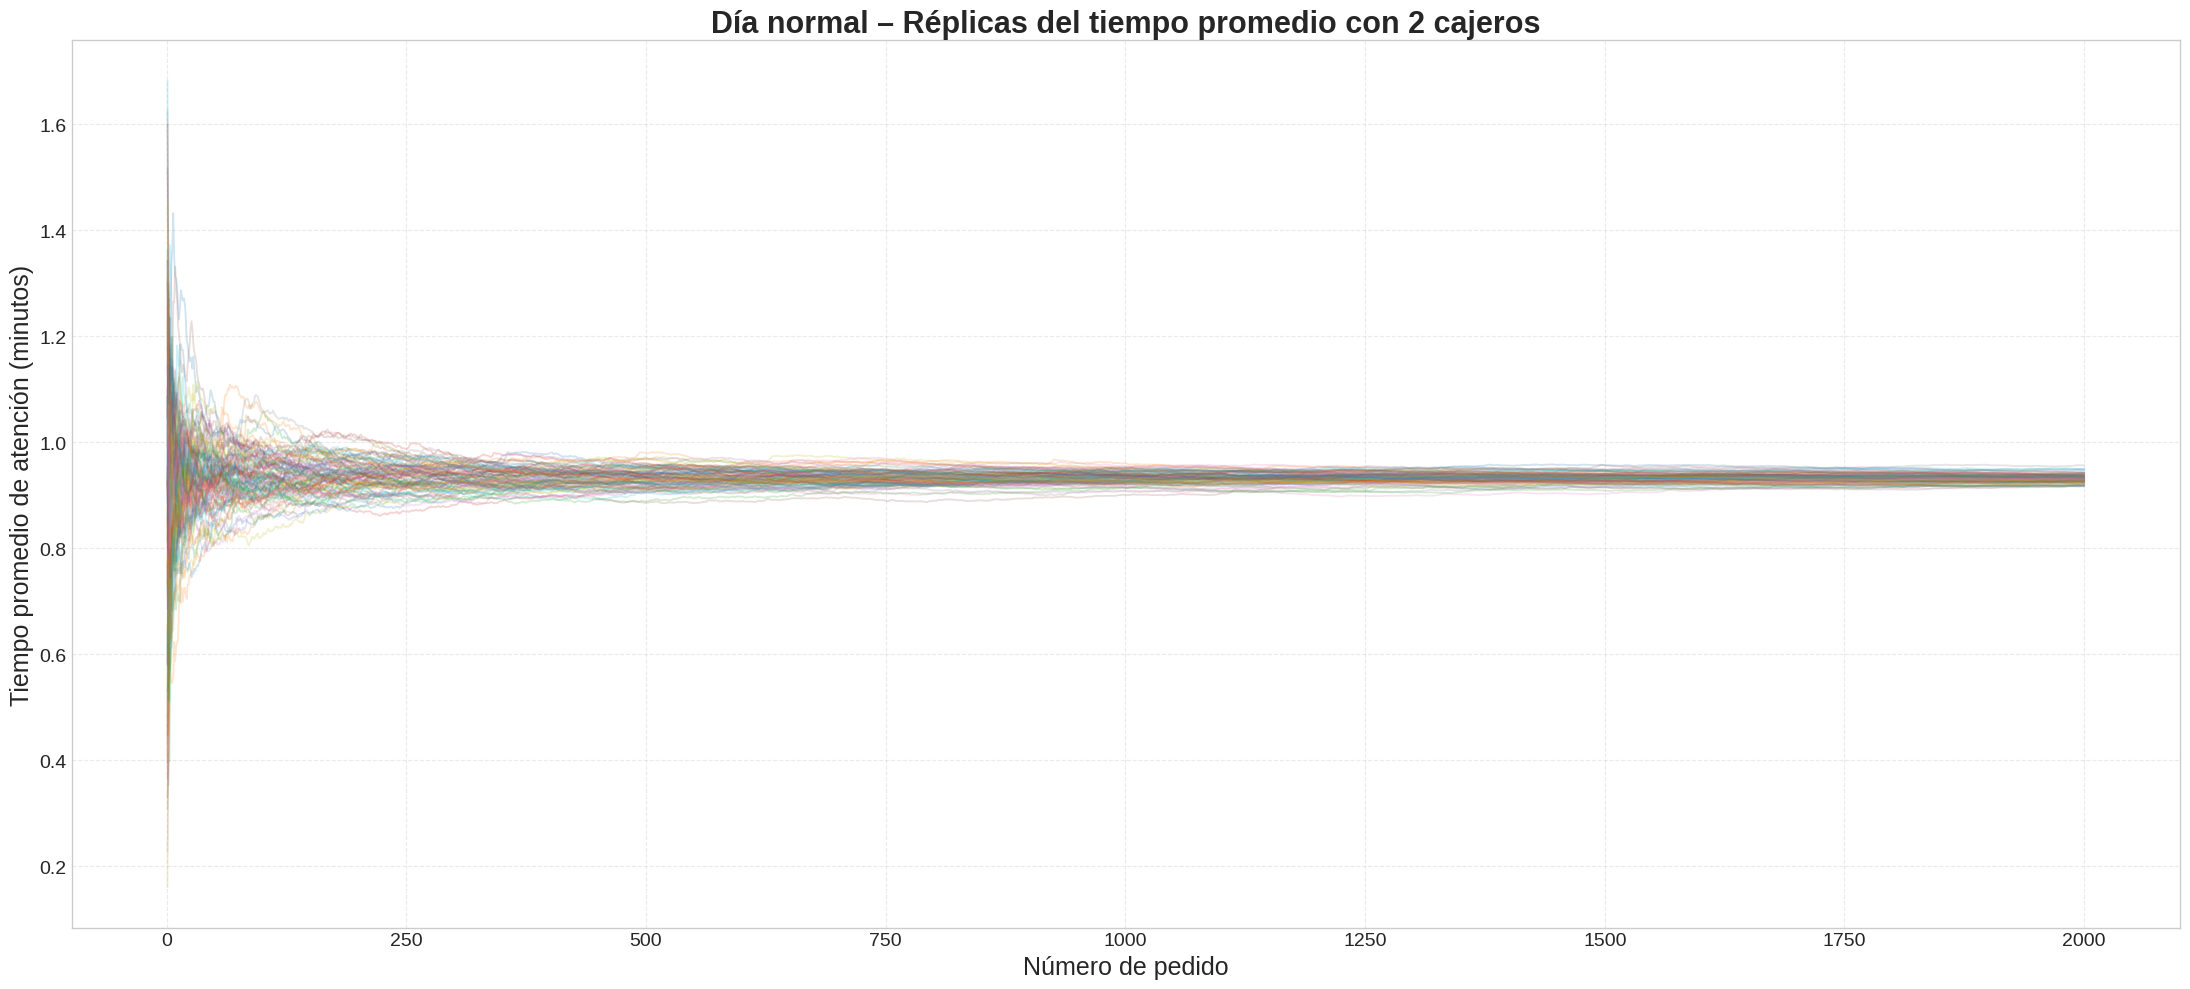

In [126]:
num_pedidos = 2000     # número de clientes por réplica
num_replicas = 100     # número de réplicas

replicas_dia_normal = []

for r in range(num_replicas):
    trayectoria, _, _ = simular_dos_cajeros(
        num_pedidos=num_pedidos,
        lam_llegadas=lam_semana,    # <-- Mantengo tus variables originales
        mu_serv=mu_semana,
        sigma_serv=sig_semana,
        num_cajeros=2,
        seed=100 + r
    )
    replicas_dia_normal.append(trayectoria)

# --- Gráfico tipo "abanico" mejorado ---
plt.style.use("seaborn-v0_8-whitegrid")

plt.figure(figsize=(22, 10))  # tamaño grande

for trayectoria in replicas_dia_normal:
    plt.plot(
        range(1, num_pedidos + 1),
        trayectoria,           # <-- AHORA ESTÁ EN MINUTOS
        alpha=0.20,
        linewidth=1.3
    )

plt.title("Día normal – Réplicas del tiempo promedio con 2 cajeros",
          fontsize=22, fontweight="bold")

plt.xlabel("Número de pedido", fontsize=18)
plt.ylabel("Tiempo promedio de atención (minutos)", fontsize=18)  # <-- CORREGIDO

plt.tick_params(axis='both', labelsize=14)
plt.grid(alpha=0.4, linestyle="--")

plt.tight_layout()
plt.show()


In [127]:
import pandas as pd
import numpy as np

NUM_REPLICAS = 100
num_pedidos = 2000   # igual que tu simulación
resultados_resumen = []

print(f"Ejecutando {NUM_REPLICAS} réplicas del sistema con 2 cajeros...\n")

for i in range(NUM_REPLICAS):

    trayectoria, tiempos_sistema, metricas = simular_dos_cajeros(
        num_pedidos=num_pedidos,
        lam_llegadas=lam_semana,
        mu_serv=mu_semana,
        sigma_serv=sig_semana,
        num_cajeros=2,
        seed=100 + i
    )

    fila = {
        "Réplica": i + 1,

        # Tiempo promedio en el sistema del día (minutos)
        "T. Prom. Sistema (min)": metricas["tiempo_prom_sistema"],

        # Tiempo promedio en cola del día (min)
        "T. Prom. Cola (min)": metricas["tiempo_prom_cola"],

        # Número promedio de clientes en cola
        "N° Prom. Cola": metricas["num_promedio_cola"],

        # Utilización promedio de los cajeros (%)
        "Utilización (%)": metricas["utilizacion"] * 100,

        # Clientes procesados ese día (siempre 2000 en tu caso)
        "Clientes Atendidos": len(tiempos_sistema)
    }

    resultados_resumen.append(fila)

# Crear DataFrame final
df_replicas = pd.DataFrame(resultados_resumen)

# Formato bonito
pd.set_option('display.float_format', '{:.3f}'.format)

# Guardar a Excel
df_replicas.to_excel("Tabla_Resultados_2_Cajeros.xlsx", index=False)

print("\nArchivo generado: Tabla_Resultados_2_Cajeros.xlsx\n")

print("--- Primeras 10 filas ---")
df_replicas.head(15)


Ejecutando 100 réplicas del sistema con 2 cajeros...


Archivo generado: Tabla_Resultados_2_Cajeros.xlsx

--- Primeras 10 filas ---


,Réplica,T. Prom. Sistema (min),T. Prom. Cola (min),N° Prom. Cola,Utilización (%),Clientes Atendidos
0,1,0.949,0.056,0.033,27.429,2000
1,2,0.940,0.038,0.023,27.057,2000
2,3,0.921,0.042,0.025,25.848,2000
3,4,0.931,0.043,0.026,26.195,2000
4,5,0.935,0.045,0.027,26.647,2000
5,6,0.919,0.040,0.024,25.765,2000
6,7,0.947,0.039,0.023,26.483,2000
7,8,0.930,0.041,0.024,26.107,2000
8,9,0.928,0.040,0.024,26.607,2000
9,10,0.933,0.040,0.024,25.727,2000


#Replicas 3 Cajeros

In [128]:
def simular_tres_cajeros(num_pedidos, lam_llegadas, mu_serv, sigma_serv, seed=None):
    """
    Simula un día de atención con 3 cajeros.
    Devuelve:
    - vector del tiempo promedio acumulado en el sistema
    - vector de tiempos en el sistema por cliente
    - métricas agregadas del día
    """
    num_cajeros = 3  # ← aquí lo fijamos explícitamente

    if seed is not None:
        np.random.seed(seed)

    # Llegadas (exponencial)
    tiempos_entre_llegadas = np.random.exponential(scale=1/lam_llegadas, size=num_pedidos)
    tiempos_llegada = np.cumsum(tiempos_entre_llegadas)

    # Servicio (normal truncada)
    tiempos_servicio = np.random.normal(loc=mu_serv, scale=sigma_serv, size=num_pedidos)
    tiempos_servicio = np.maximum(tiempos_servicio, 0.01)

    # Estado de cajeros
    cajeros_libres = np.zeros(num_cajeros)

    # Resultados por cliente
    tiempos_espera = np.zeros(num_pedidos)
    tiempos_en_sistema = np.zeros(num_pedidos)

    # --- Simulación cliente por cliente ---
    for i in range(num_pedidos):

        t_llegada = tiempos_llegada[i]

        idx = np.argmin(cajeros_libres)   # cajero que se libera primero
        t_libre = cajeros_libres[idx]

        t_inicio = max(t_llegada, t_libre)
        t_fin = t_inicio + tiempos_servicio[i]

        cajeros_libres[idx] = t_fin

        tiempos_espera[i] = t_inicio - t_llegada
        tiempos_en_sistema[i] = t_fin - t_llegada

    # --- Métricas diarias ---
    tiempo_promedio_acumulado = np.cumsum(tiempos_en_sistema) / np.arange(1, num_pedidos + 1)

    horizonte = np.max(cajeros_libres)
    utilizacion = np.sum(tiempos_servicio) / (num_cajeros * horizonte)

    metricas = {
        "tiempo_prom_sistema": np.mean(tiempos_en_sistema),
        "tiempo_prom_cola": np.mean(tiempos_espera),
        "utilizacion": utilizacion,
        "num_promedio_cola": lam_llegadas * np.mean(tiempos_espera)  # Ley de Little
    }

    return tiempo_promedio_acumulado, tiempos_en_sistema, metricas


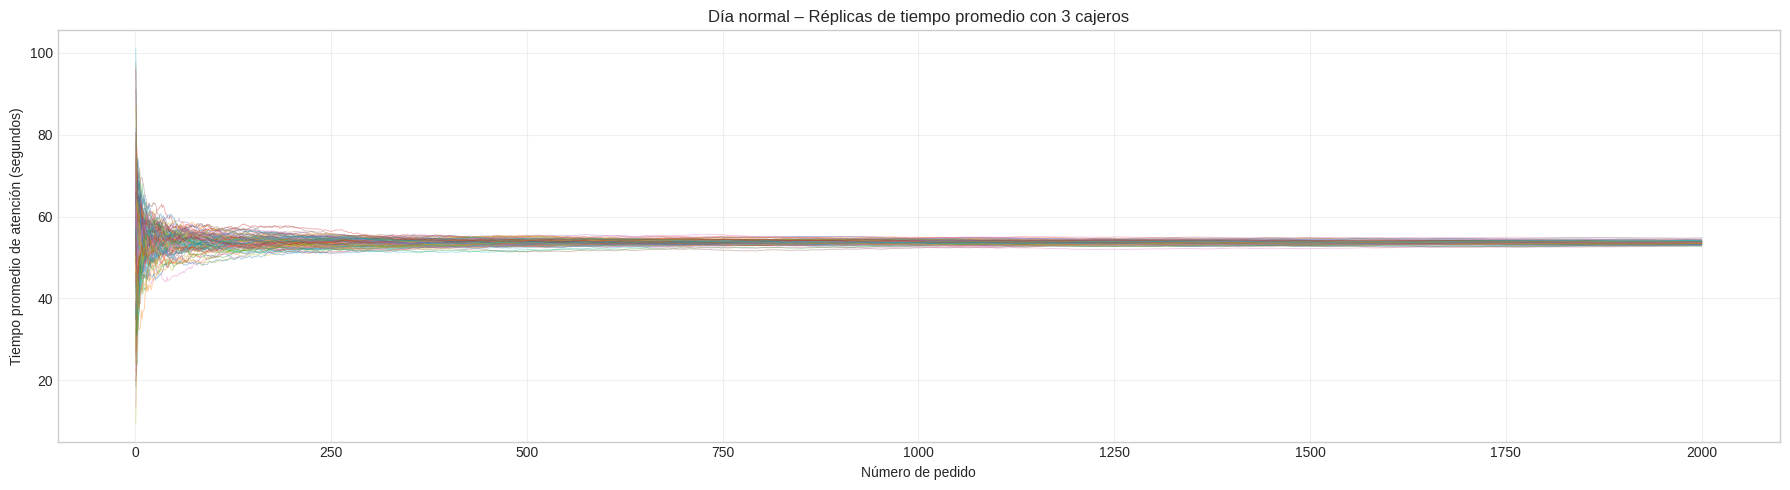

In [129]:
num_pedidos = 2000     # número de clientes por réplica
num_replicas = 100     # número de réplicas

replicas_dia_normal = []

for r in range(num_replicas):
    trayectoria, _, _ = simular_tres_cajeros(  # función especial para 3 cajeros
        num_pedidos=num_pedidos,
        lam_llegadas=lam_semana,
        mu_serv=mu_semana,
        sigma_serv=sig_semana,
        seed=100 + r
    )
    replicas_dia_normal.append(trayectoria)

# Gráfico tipo abanico
plt.figure(figsize=(18, 5))
for trayectoria in replicas_dia_normal:
    plt.plot(range(1, num_pedidos + 1), trayectoria * 60,   # convertir a segundos
             alpha=0.4, linewidth=0.6)

plt.title("Día normal – Réplicas de tiempo promedio con 3 cajeros")
plt.xlabel("Número de pedido")
plt.ylabel("Tiempo promedio de atención (segundos)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [130]:
import pandas as pd
import numpy as np

NUM_REPLICAS = 100
num_pedidos = 2000
resultados_resumen = []

print(f"Ejecutando {NUM_REPLICAS} réplicas con 3 cajeros...\n")

for i in range(NUM_REPLICAS):

    trayectoria, tiempos_sistema, metricas = simular_tres_cajeros(
        num_pedidos=num_pedidos,
        lam_llegadas=lam_semana,
        mu_serv=mu_semana,
        sigma_serv=sig_semana,
        seed=200 + i
    )

    fila = {
        "Réplica": i + 1,

        # Tiempo promedio total que pasó un cliente en el sistema
        "T. Prom. Sistema (min)": metricas["tiempo_prom_sistema"],

        # Tiempo promedio que esperó en cola
        "T. Prom. Cola (min)": metricas["tiempo_prom_cola"],

        # Número promedio de clientes en cola
        "N° Prom. Cola": metricas["num_promedio_cola"],

        # Utilización de los 3 cajeros
        "Utilización (%)": metricas["utilizacion"] * 100,

        # Total de clientes atendidos
        "Clientes Atendidos": len(tiempos_sistema)
    }

    resultados_resumen.append(fila)

# Convertir a DataFrame
df_3cajeros = pd.DataFrame(resultados_resumen)

# Formato visual
pd.set_option('display.float_format', '{:.3f}'.format)

# Guardar a Excel
df_3cajeros.to_excel("Tabla_Resultados_3_Cajeros.xlsx", index=False)
print("\nArchivo generado: Tabla_Resultados_3_Cajeros.xlsx")

# Mostrar primeras 10 filas
print("\n--- PRIMERAS 10 FILAS ---")
df_3cajeros.head(15)


Ejecutando 100 réplicas con 3 cajeros...


Archivo generado: Tabla_Resultados_3_Cajeros.xlsx

--- PRIMERAS 10 FILAS ---


,Réplica,T. Prom. Sistema (min),T. Prom. Cola (min),N° Prom. Cola,Utilización (%),Clientes Atendidos
0,1,0.882,0.004,0.002,16.995,2000
1,2,0.900,0.004,0.002,18.337,2000
2,3,0.892,0.005,0.003,17.823,2000
3,4,0.892,0.004,0.002,17.105,2000
4,5,0.887,0.004,0.002,17.935,2000
5,6,0.897,0.003,0.002,17.071,2000
6,7,0.893,0.005,0.003,17.652,2000
7,8,0.894,0.004,0.002,17.242,2000
8,9,0.894,0.004,0.002,17.331,2000
9,10,0.898,0.004,0.002,17.727,2000


##Curva representativa de un solo experimento

In [131]:
trayectoria_unica, tiempos_sistema_unicos = simular_dos_cajeros(
    num_pedidos=num_pedidos,
    lam_llegadas=lam_semana,
    mu_serv=mu_semana,
    sigma_serv=sig_semana,
    num_cajeros=2,
    seed=999
)

plt.figure(figsize=(12, 4))
plt.plot(range(1, num_pedidos + 1), trayectoria_unica * 60,
         label="Día normal", color="blue")

plt.title("Simulación de tiempo promedio de atención (2 cajeros) — Día normal")
plt.xlabel("Número de pedidos")
plt.ylabel("Tiempo promedio de atención (segundos)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Tiempo promedio final en el sistema (día normal, 2 cajeros): {trayectoria_unica[-1]*60:.2f} segundos")


ValueError: too many values to unpack (expected 2)

##Comparar día normal vs fin de semana

In [ ]:
trayectoria_semana, _ = simular_dos_cajeros(
    num_pedidos=num_pedidos,
    lam_llegadas=lam_semana,
    mu_serv=mu_semana,
    sigma_serv=sig_semana,
    num_cajeros=2,
    seed=2025
)

trayectoria_finde, _ = simular_dos_cajeros(
    num_pedidos=num_pedidos,
    lam_llegadas=lam_finde,
    mu_serv=mu_finde,
    sigma_serv=sig_finde,
    num_cajeros=2,
    seed=2026
)

plt.figure(figsize=(12, 4))
plt.plot(range(1, num_pedidos + 1), trayectoria_semana * 60,
         label="Día normal (Miércoles+Viernes)", color="blue")
plt.plot(range(1, num_pedidos + 1), trayectoria_finde * 60,
         label="Fin de semana (Sábado)", color="orange")

plt.title("Simulación de tiempo promedio de atención (2 cajeros)\nDía normal vs fin de semana – Solari")
plt.xlabel("Número de pedidos")
plt.ylabel("Tiempo promedio de atención (segundos)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
